<a href="https://colab.research.google.com/github/kittisaktaoma/GO-tools-comparsion/blob/master/GO_tools_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and prepare package

In [ ]:
install.packages(c("data.table","factoextra"))
install.packages(c("Himsc")) 
install.packages(c("klaR","splitstackshape"))
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
library(devtools)
install_github("omegahat/XML")
install_github("harrelfe/Hmisc")
BiocManager::install("GSEABase")
BiocManager::install("GO.db")
install.packages("pheatmap")
install.packages("irr")
install.packages("dendextend")
install.packages("extrafont")
install.packages("UpSetR")
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("ComplexHeatmap")
install.packages("circlize")
install.packages("FSA")

In [ ]:
library(dendextend)
library(ggplot2)
library(data.table)
library(factoextra)
library(dplyr)
library(data.table)
library(corrplot)
library(RColorBrewer)
library(Hmisc)
library(ggrepel)
library(ComplexHeatmap)
library(devtools)
library(ggpubr)
library(reshape2)
library(klaR)
library(purrr)
library(splitstackshape)
library(broom)
library(circlize)
library(GSEABase)
library(GO.db)
library(rstatix)
library(tidyverse)
library(irr)
library(extrafont)
font_import()
library(UpSetR)
library(FSA)

In [62]:
font_custom <-   theme(text = element_text(size=25,family = 'Arial'),
                    axis.text.y   = element_text(size=25,family = 'Arial',color="black"),
                    axis.text.x = element_text(size = 25,angle = 90, hjust = 1,family = 'Arial',color="black"),
                    axis.title.y  = element_text(size=25,family = 'Arial',color="black"),
                    axis.title.x  = element_text(size=25,family = 'Arial',color="black"),
                    strip.text.x = element_text(size = 30,family = 'Arial',color="black"),
                    strip.text.y = element_text(size = 30,family = 'Arial',color="black"),
                    legend.title=element_text(size=25,family = 'Arial'), 
                    legend.text=element_text(size=25,family = 'Arial'))

font_custom.02 <-   theme(text = element_text(size=16,family = 'Arial'),
                    axis.text.y   = element_text(size=16,family = 'Arial',color="black"),
                    axis.text.x = element_text(size = 16,family = 'Arial',color="black"),
                    axis.title.y  = element_text(size=16,family = 'Arial',color="black"),
                    axis.title.x  = element_text(size=16,family = 'Arial',color="black"),
                    strip.text.x = element_text(size = 16,family = 'Arial',color="black"),
                    strip.text.y = element_text(size = 16,family = 'Arial',color="black"),
                    legend.title=element_text(size=16,family = 'Arial'), 
                    legend.text=element_text(size=16,family = 'Arial'))

# **SEA characteristics of 10 GO annotation and enrichment analysis tools** 

## Binary Heatmap

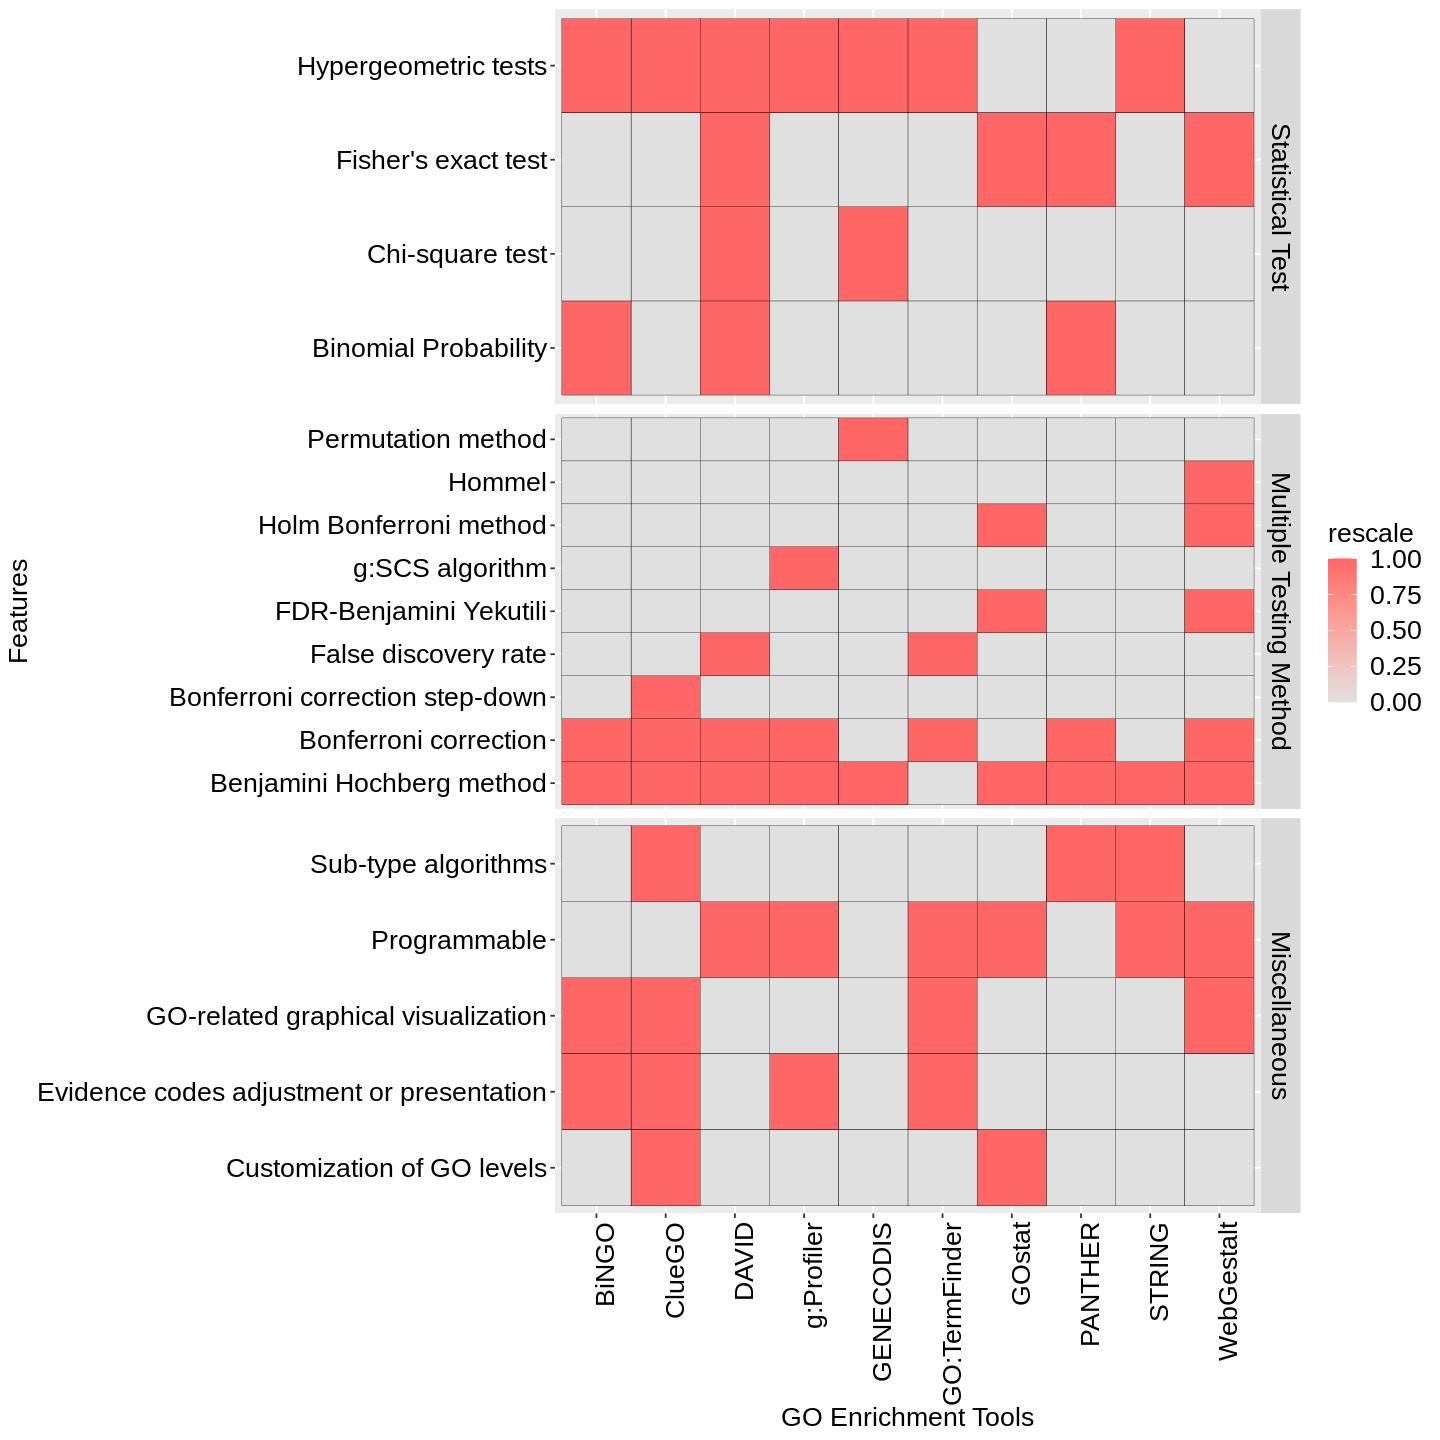

In [4]:
# Characteristics 
df1.m <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Characteristics.txt")
df1.m$type <- factor(df1.m$type, levels = c("Statistical Test","Multiple Testing Method","Miscellaneous"))
# Make plots wider 
options(repr.plot.width=12, repr.plot.height=12)
ggplot(df1.m, aes(x=Database, y=variable)) +
  geom_tile(aes(fill = rescale), colour = "black") +
  scale_fill_gradient(low = "#E0E0E0", high = "#FF6666") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(colors = "") +theme(axis.text=element_text(size=12)) +
  ylab("Features") +
  xlab("GO Enrichment Tools") +
  facet_grid(type ~ .,scales = "free") + font_custom

## K-mean clustering

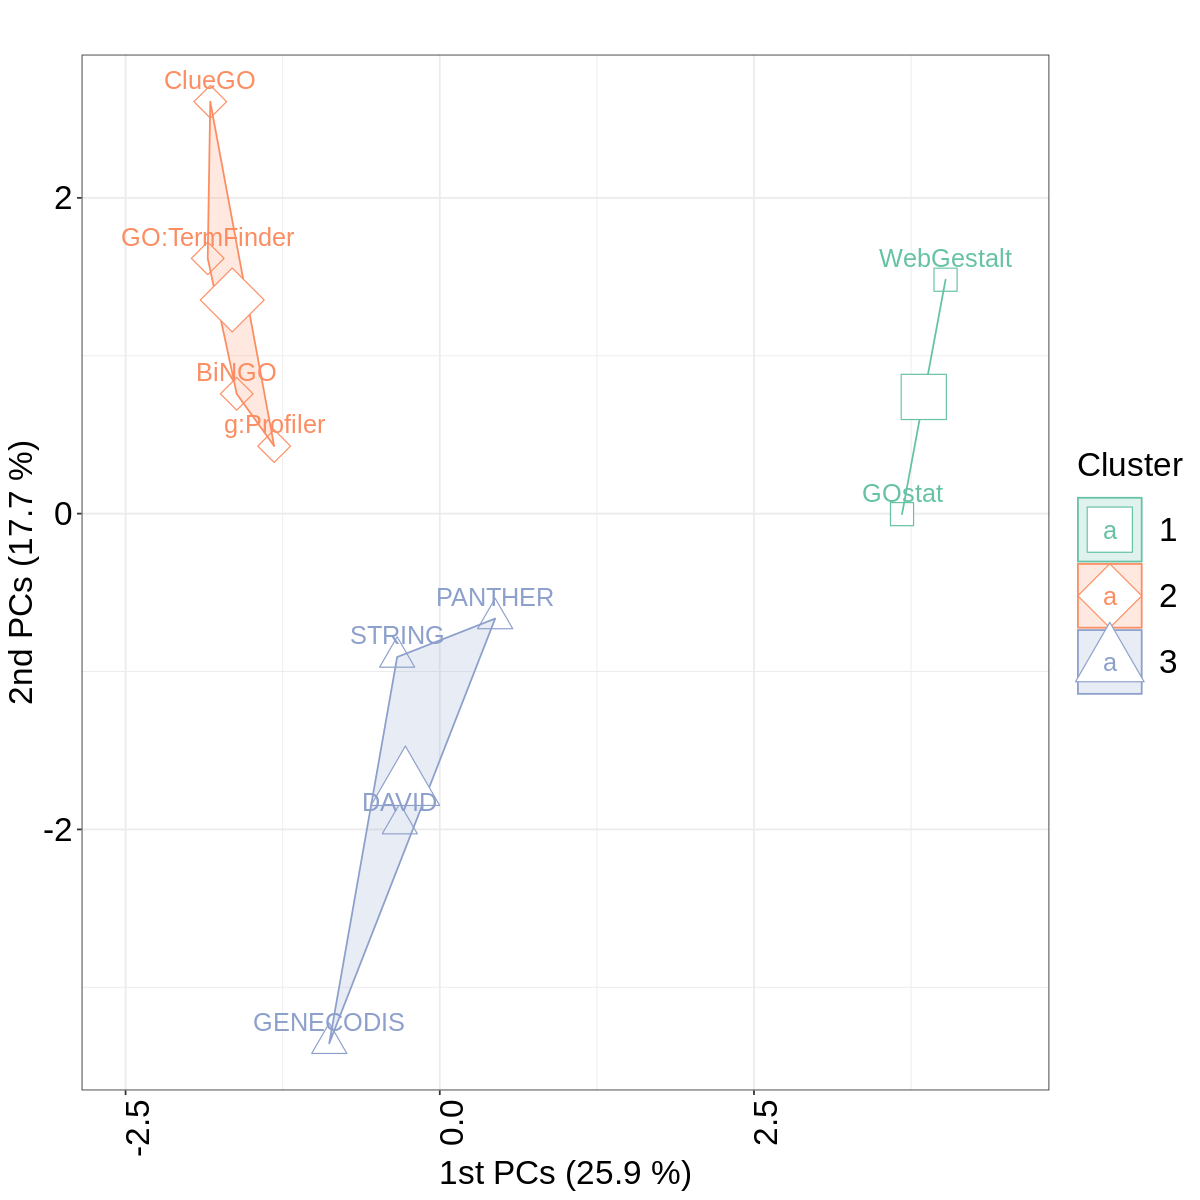

In [49]:
set.seed(123)
kdf <-  fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Tools_Properties_Binary.csv") %>% as.data.frame()
df <- kdf[,-1]
rownames(df) <- kdf[,1]
# function to compute total within-cluster sum of square 
wss <- function(k) {
  kmeans(df, k, nstart = 20 )$tot.withinss
}

# Compute and plot wss for k = 1 to k = 15
k.values <- 1:8

# extract wss for 2-15 clusters
wss_values <- map_dbl(k.values, wss)

#plot(k.values, wss_values,
#     type="b", pch = 19, frame = FALSE, 
#    xlab="Number of clusters K",
#    ylab="Total within-clusters sum of squares")


final <- kmeans(df, 3, nstart = 50,iter.max = 100)

# Make plots wider 
options(repr.plot.width=10, repr.plot.height=10)
fviz_cluster(final, data = df,
labelsize = 16,
ellipse = T,
show.clust.cent = T,
ellipse.type = "convex",
pointsize = 7,
ggtheme = theme_bw()) +
  theme_bw() +
  xlim(-2.5,4.5)  +
  scale_color_brewer('Cluster', palette='Set2') + 
  scale_fill_brewer('Cluster', palette='Set2') +
  scale_shape_manual('Cluster', values=c(22,23,24)) + 
  ggtitle(label='')+font_custom +
  xlab("1st PCs (25.9 %)") +
  ylab("2nd PCs (17.7 %)")

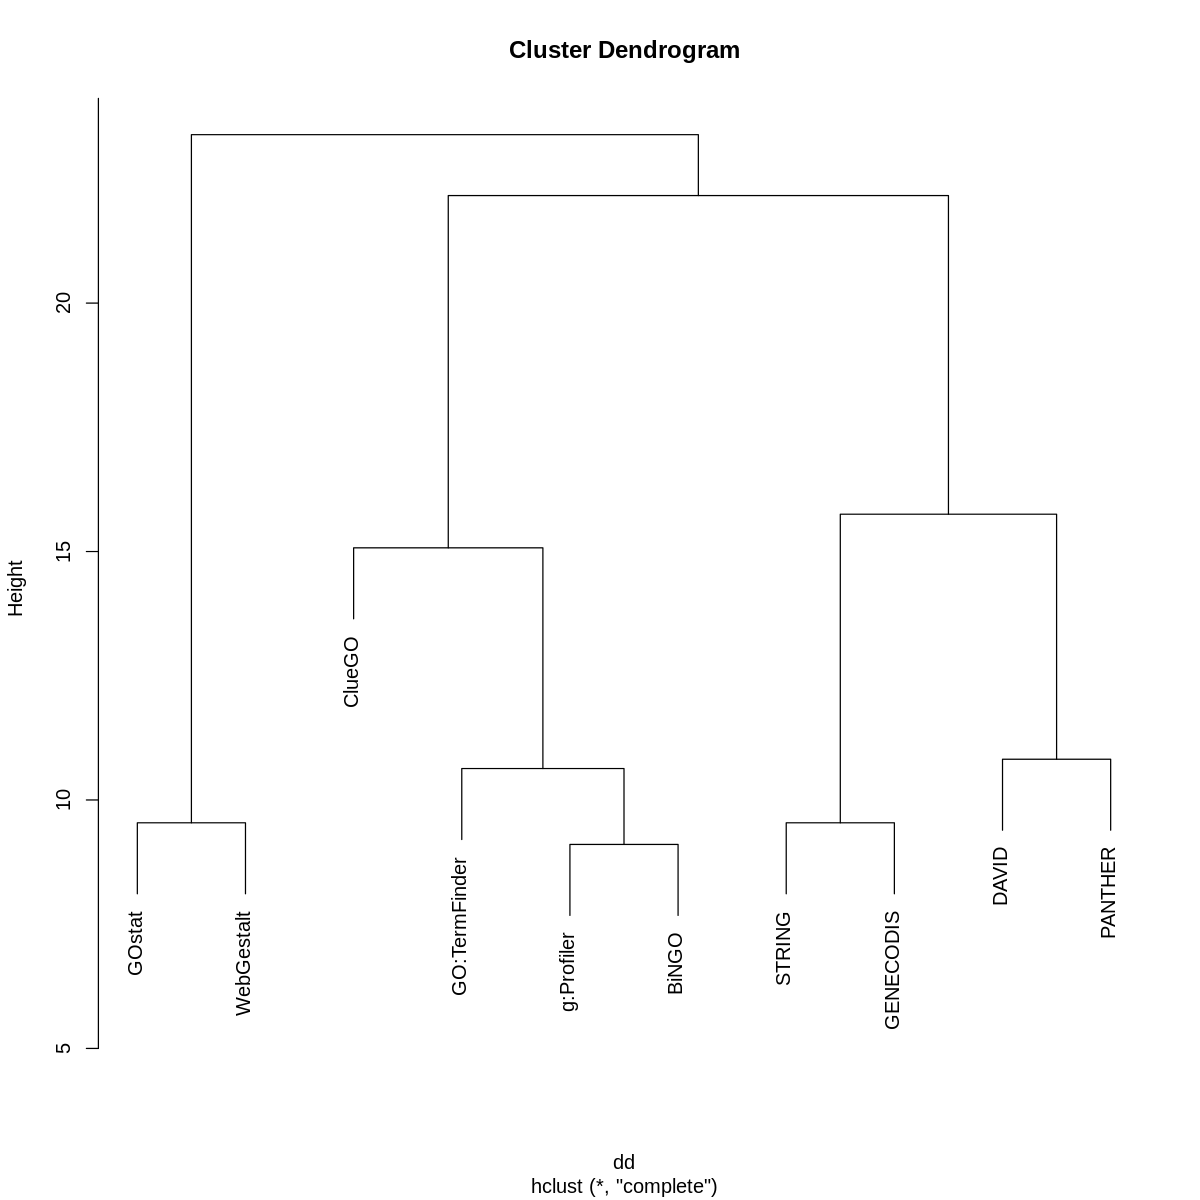

In [50]:
#"euclidean", "maximum", "manhattan", "canberra", "binary" or "minkowski"
dd <- dist(scale(df), method = "manhattan")
#"ward.D", "ward.D2", "single", "complete", "average" (= UPGMA), "mcquitty" (= WPGMA), "median" (= WPGMC) or "centroid" (= UPGMC)
options(repr.plot.width=10, repr.plot.height=10)
hc <- hclust(dd, method = "complete")
plot(hc) 

#Hyperparameter in 10 Tools

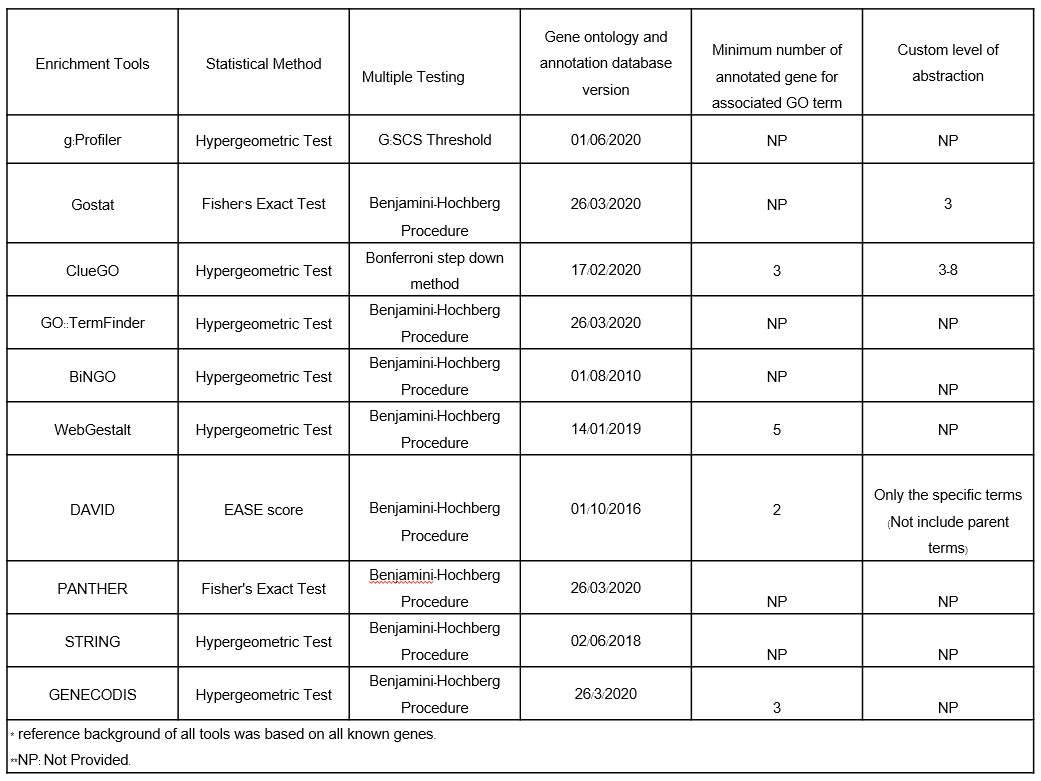

# **The proportion of identified GO term in three categories**


## summary of GO term Frequency

In [34]:
df_01 <- read.csv("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt",sep="\t")
head(df_01)

,gene,id,fdr,ref,des,type,dataset,database,condition
,<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,YWHAG,GO:0008426,0.00475653,18483,protein kinase C inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
2,HSPB1,GO:0008426,0.00475653,18483,protein kinase C inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
3,GPI,GO:0004347,0.04792210,18483,glucose-6-phosphate isomerase activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
4,UBE2I,GO:0061656,0.04792210,18483,SUMO conjugating enzyme activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
5,CAV1,GO:0070320,0.04792210,18483,inward rectifier potassium channel inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
6,CCT8,GO:1904851,0.04075850,18883,positive regulation of establishment of protein localization to telomere,Biological Process,Caffeine Dataset,GENECODIS,Unique


In [35]:
count_02 <-df_01[,-1] %>% unique() %>% group_by(database,dataset,type) %>% dplyr::summarise(count=n()) %>% as.data.frame() 
resh <- reshape(count_02, idvar = c("database","dataset"), timevar = "type", direction = "wide")
names(resh) <- c("database","dataset","Biological Process","Cellular Component","Molecular Function")
resh.02 <- resh %>% melt()
resh.03 <- cbind(resh.02 %>% filter(dataset == "Caffeine Dataset"),resh.02 %>% filter(dataset == "EGCG Dataset"))
resh.04 <- resh.03[,c(1,2,3,4,8)]
names(resh.04) <- c("database","dataset","type","Caffeine","EGCG")
resh.04$cat <- "Freq"
GO_freq <- resh.04[,-2]
GO_freq

`summarise()` regrouping output by 'database', 'dataset' (override with `.groups` argument)

Using database, dataset as id variables



database,type,Caffeine,EGCG,cat
<fct>,<fct>,<int>,<int>,<chr>
BiNGO,Biological Process,55,56,Freq
ClueGO,Biological Process,56,76,Freq
DAVID,Biological Process,9,99,Freq
g:Profiler,Biological Process,73,64,Freq
GENECODIS,Biological Process,52,74,Freq
GO::TERMFINDER,Biological Process,85,75,Freq
GOstat,Biological Process,106,137,Freq
PANTHER,Biological Process,187,209,Freq
STRING,Biological Process,135,141,Freq


## Variation Within Dataset

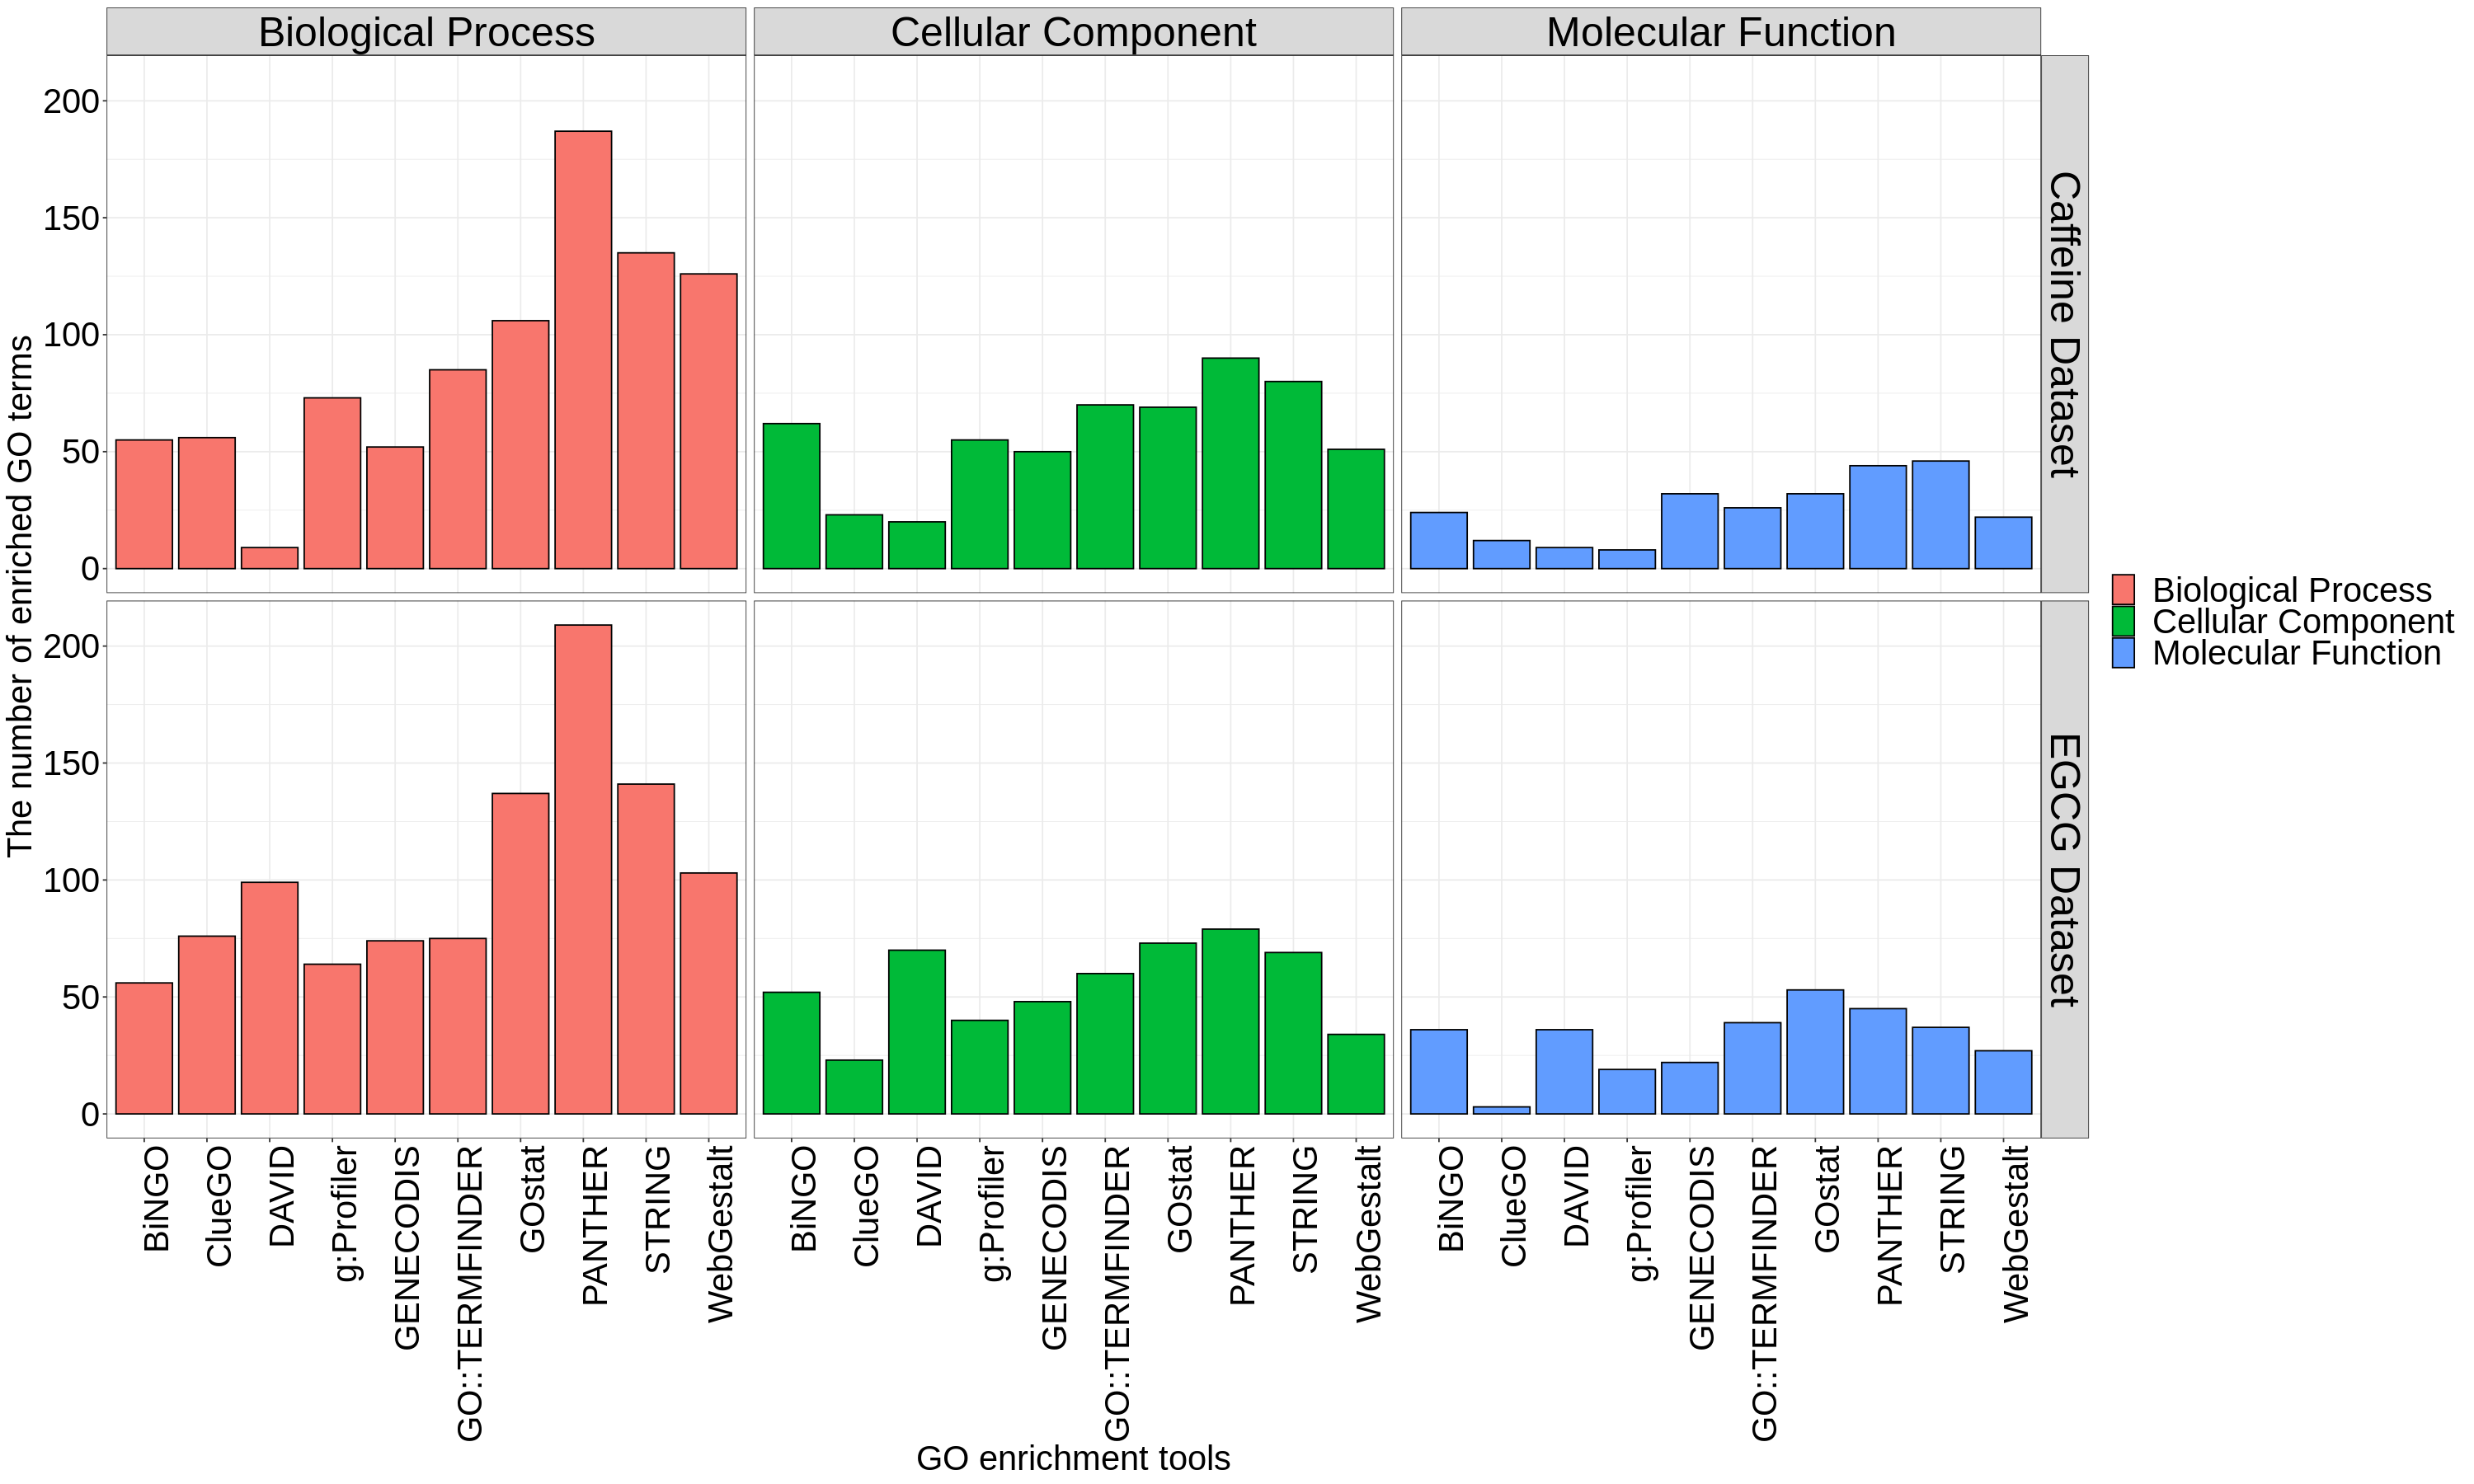

In [63]:
options(repr.plot.width=25, repr.plot.height=15)
 
ggplot(count_02,aes(x=database, y=count,fill=type)) +
  geom_bar(stat="identity", color="black", position=position_dodge()) +
  theme_bw() +
  facet_grid(cols=vars(type),rows=vars(dataset)) +
  labs(fill = "") +
  xlab("GO enrichment tools") +
  ylab("The number of enriched GO terms") +
  scale_fill_discrete(name = "", labels = c("Biological Process",
                                                "Cellular Component",
                                                "Molecular Function")) +
                                                font_custom

#### Chi-square Test

In [37]:
for (i in unique(df_01$dataset) %>% unlist()) {
  print(i)
  Chi_squre_within <- df_01[,c(2,6,7,8)] %>% unique
  Chi_squre_within.02 <- Chi_squre_within %>% filter(.,dataset == i) %>% select(-dataset,-id) 
  Chi_squre_within.03 <- table(Chi_squre_within.02$database,Chi_squre_within.02$type)
  Chi_squre_within.04 <- chisq.test(Chi_squre_within.03)  
  print(Chi_squre_within.04$statistic)
  print(Chi_squre_within.04$p.value)}

[1] "Caffeine Dataset"
X-squared 
 67.64998 
[1] 1.124195e-07
[1] "EGCG Dataset"
X-squared 
 68.89196 
[1] 6.95257e-08


#### Heatmap For Pairwise Comparison

In [ ]:
pairs_wise <- function(k){
  Chi_squre_within <- df_01[,c(2,6,7,8)] %>% unique
  Chi_squre_within.02 <- Chi_squre_within %>% filter(.,dataset == k) %>% select(-dataset,-id) 
  x.02 <- table(Chi_squre_within.02$type,Chi_squre_within.02$database) %>% as.data.frame()  
  x.03 <- reshape(x.02, idvar = "Var1", timevar = "Var2", direction = "wide")
  x.04 <- x.03[,-1]
  rownames(x.04) <- x.03[,1]
  x.02 <- x.04
  names(x.02) <- c("BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
  # initialization
  out_list <- list()
  column <- 1
  # cycle for storing kappa2's output structure
  for (i in 1:(ncol(x.02)-1)){
   for (j in (i+1):ncol(x.02)){
      x <- chisq.test(x.02[,c(i,j)])
      out_list[[column]] <- x$p.value
      # renaming the elements
      names(out_list)[column] <- paste0(colnames(x.02[i]), "_", colnames(x.02[j]))
      column <- column + 1
    }
  }

  res <- do.call(rbind,out_list) %>% as.data.frame()
  res$data <- rownames(res)
  res.1 <- splitstackshape::cSplit(res, "data", "_")
  res.1$type <- k

  p.adj <- p.adjust(unlist(res.1[,1]), method = "fdr")
  res.1$adj <- as.data.frame(p.adj)
  return(res.1)
}


In [ ]:
res.caf <- pairs_wise("Caffeine Dataset")
res.egcg <- pairs_wise("EGCG Dataset")

res.all <- rbind(res.caf,res.egcg)
res.all$data_2 <- gsub(".[0-9]", "", res.all$data_2)

res.all$sig <- ifelse(res.all$adj < 0.001,"***",
                      ifelse(res.all$adj < 0.01,"**",
                             ifelse(res.all$adj < 0.05,"*","ns")))
res.all

Warning message in chisq.test(x.02[, c(i, j)]):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(x.02[, c(i, j)]):
“Chi-squared approximation may be incorrect”


V1,data_1,data_2,type,adj,sig
<dbl>,<fct>,<chr>,<chr>,<dbl>,<chr>
2.924483e-03,BiNGO,ClueGO,Caffeine Dataset,0.0120903071,*
2.042855e-01,BiNGO,DAVID,Caffeine Dataset,0.2703779318,ns
4.375782e-03,BiNGO,g:Profiler,Caffeine Dataset,0.0140650124,*
3.109859e-01,BiNGO,GENECODIS,Caffeine Dataset,0.3588298967,ns
3.576848e-01,BiNGO,GO::TERMFINDER,Caffeine Dataset,0.4023954177,ns
6.900068e-02,BiNGO,GOstat,Caffeine Dataset,0.1035010244,ns
4.952626e-04,BiNGO,PANTHER,Caffeine Dataset,0.0024763131,**
2.075584e-02,BiNGO,STRING,Caffeine Dataset,0.0479399967,*
5.308125e-05,BiNGO,WebGestalt,Caffeine Dataset,0.0007962188,***


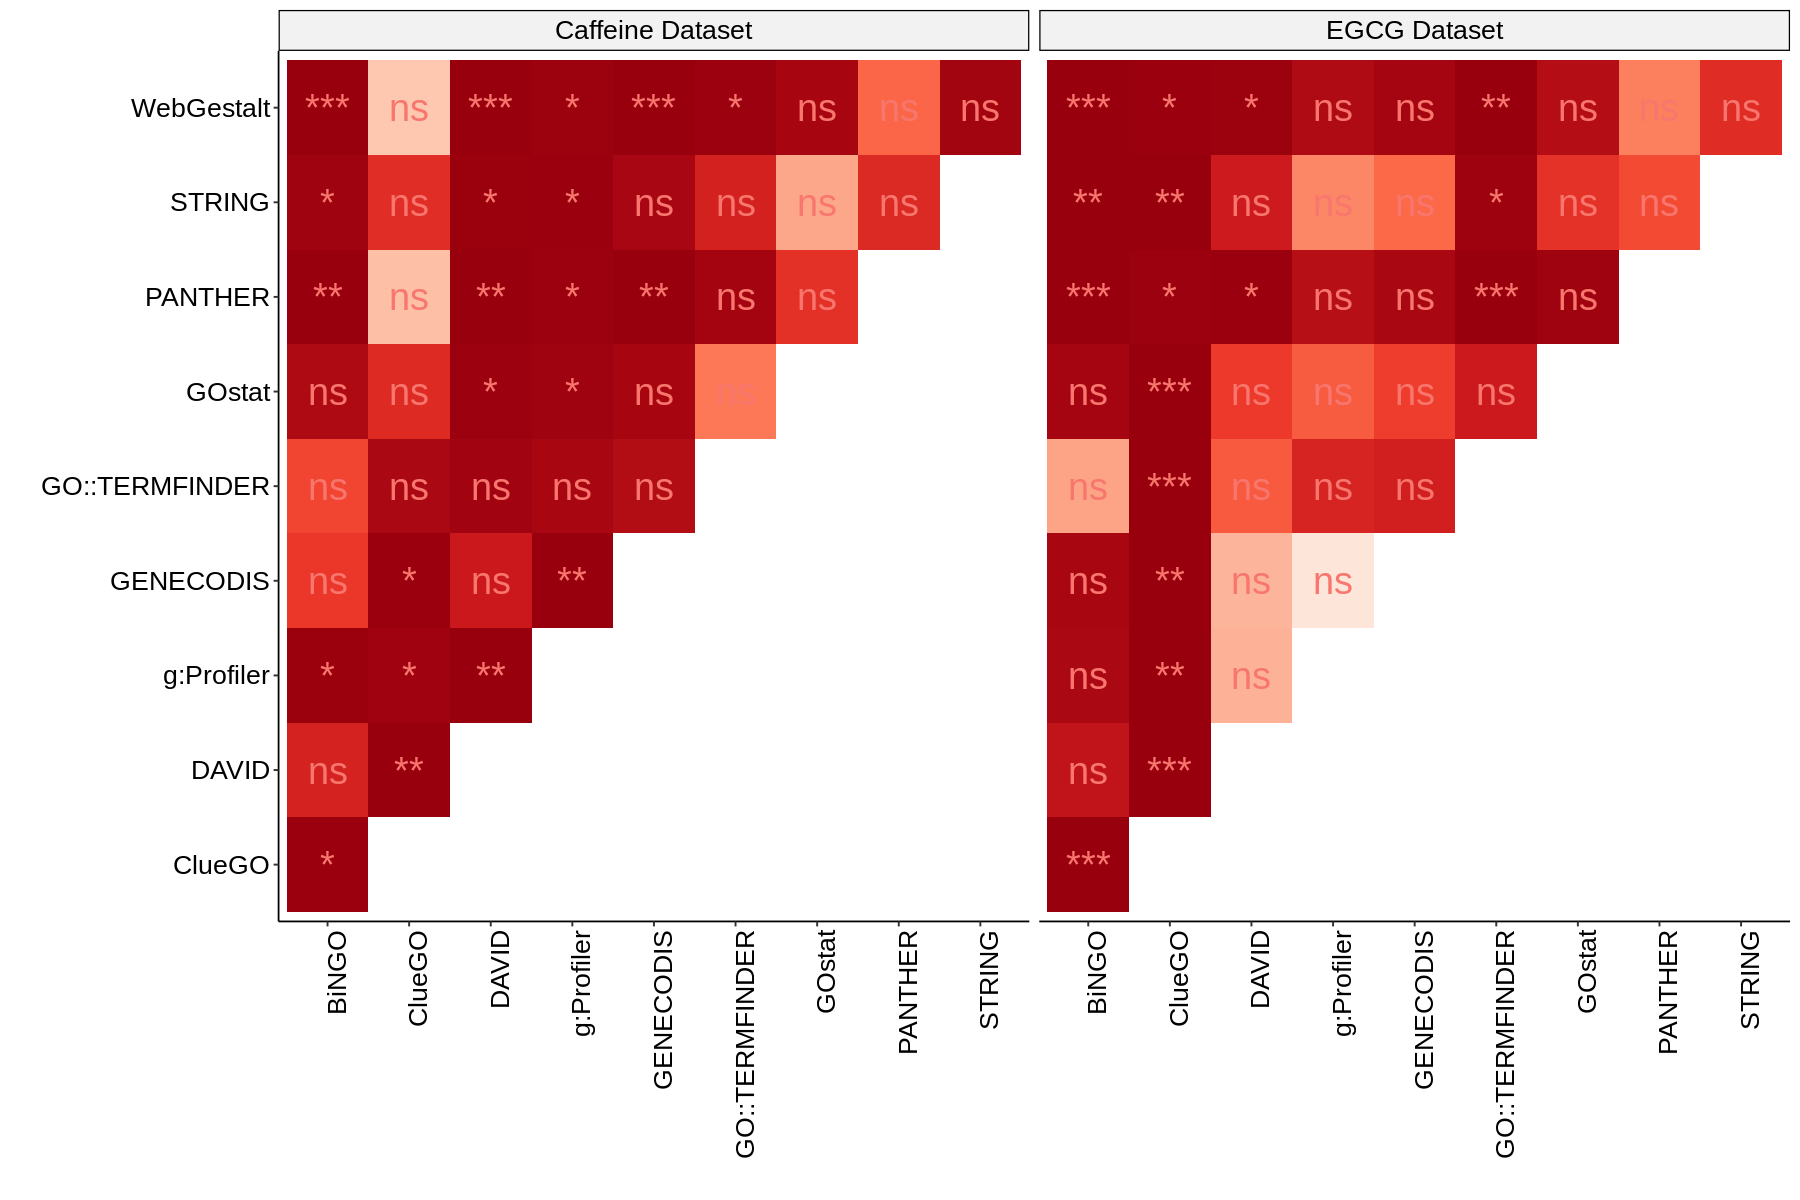

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data = res.all, aes(x = data_1, y = data_2)) +
  geom_tile(aes(fill=V1))+
  facet_grid(cols=vars(type)) + 
  theme_pubr() +
  geom_text(aes(label=sig,color="white"),cex=8)+
  theme(legend.position="none") +
  scale_fill_distiller(palette = "Reds") +
  xlab("") +
  ylab("") + font_custom

# **The comparison of the number of annotated gene**

## summary of GO term Frequency

In [51]:
df_j <- df_01 %>% select(gene,dataset,database,type) %>% unique() %>% group_by(dataset,database,type) %>% summarise(CNT=n()) 
df_j$con <- "Remaining genes"
df_j.02 <- cbind(df_j %>% filter(dataset=="Caffeine Dataset"),
      df_j %>% filter(dataset=="EGCG Dataset"))

df_j.03 <- df_j.02[,-c(1,5,6,7,8,10)]
names(df_j.03) <- c("database","type","Caffeine","EGCG")
df_j.03$cat <- "Annotated Gene"
annotate_gene <- df_j.03
annotate_gene

`summarise()` regrouping output by 'dataset', 'database' (override with `.groups` argument)

New names:
* dataset -> dataset...1
* database -> database...2
* type -> type...3
* CNT -> CNT...4
* con -> con...5
* ...



database,type,Caffeine,EGCG,cat
<fct>,<fct>,<int>,<int>,<chr>
BiNGO,Biological Process,104,109,Annotated Gene
BiNGO,Cellular Component,114,126,Annotated Gene
BiNGO,Molecular Function,115,126,Annotated Gene
ClueGO,Biological Process,75,85,Annotated Gene
ClueGO,Cellular Component,61,64,Annotated Gene
ClueGO,Molecular Function,30,18,Annotated Gene
DAVID,Biological Process,38,127,Annotated Gene
DAVID,Cellular Component,117,136,Annotated Gene
DAVID,Molecular Function,101,128,Annotated Gene


## Variation Within Dataset

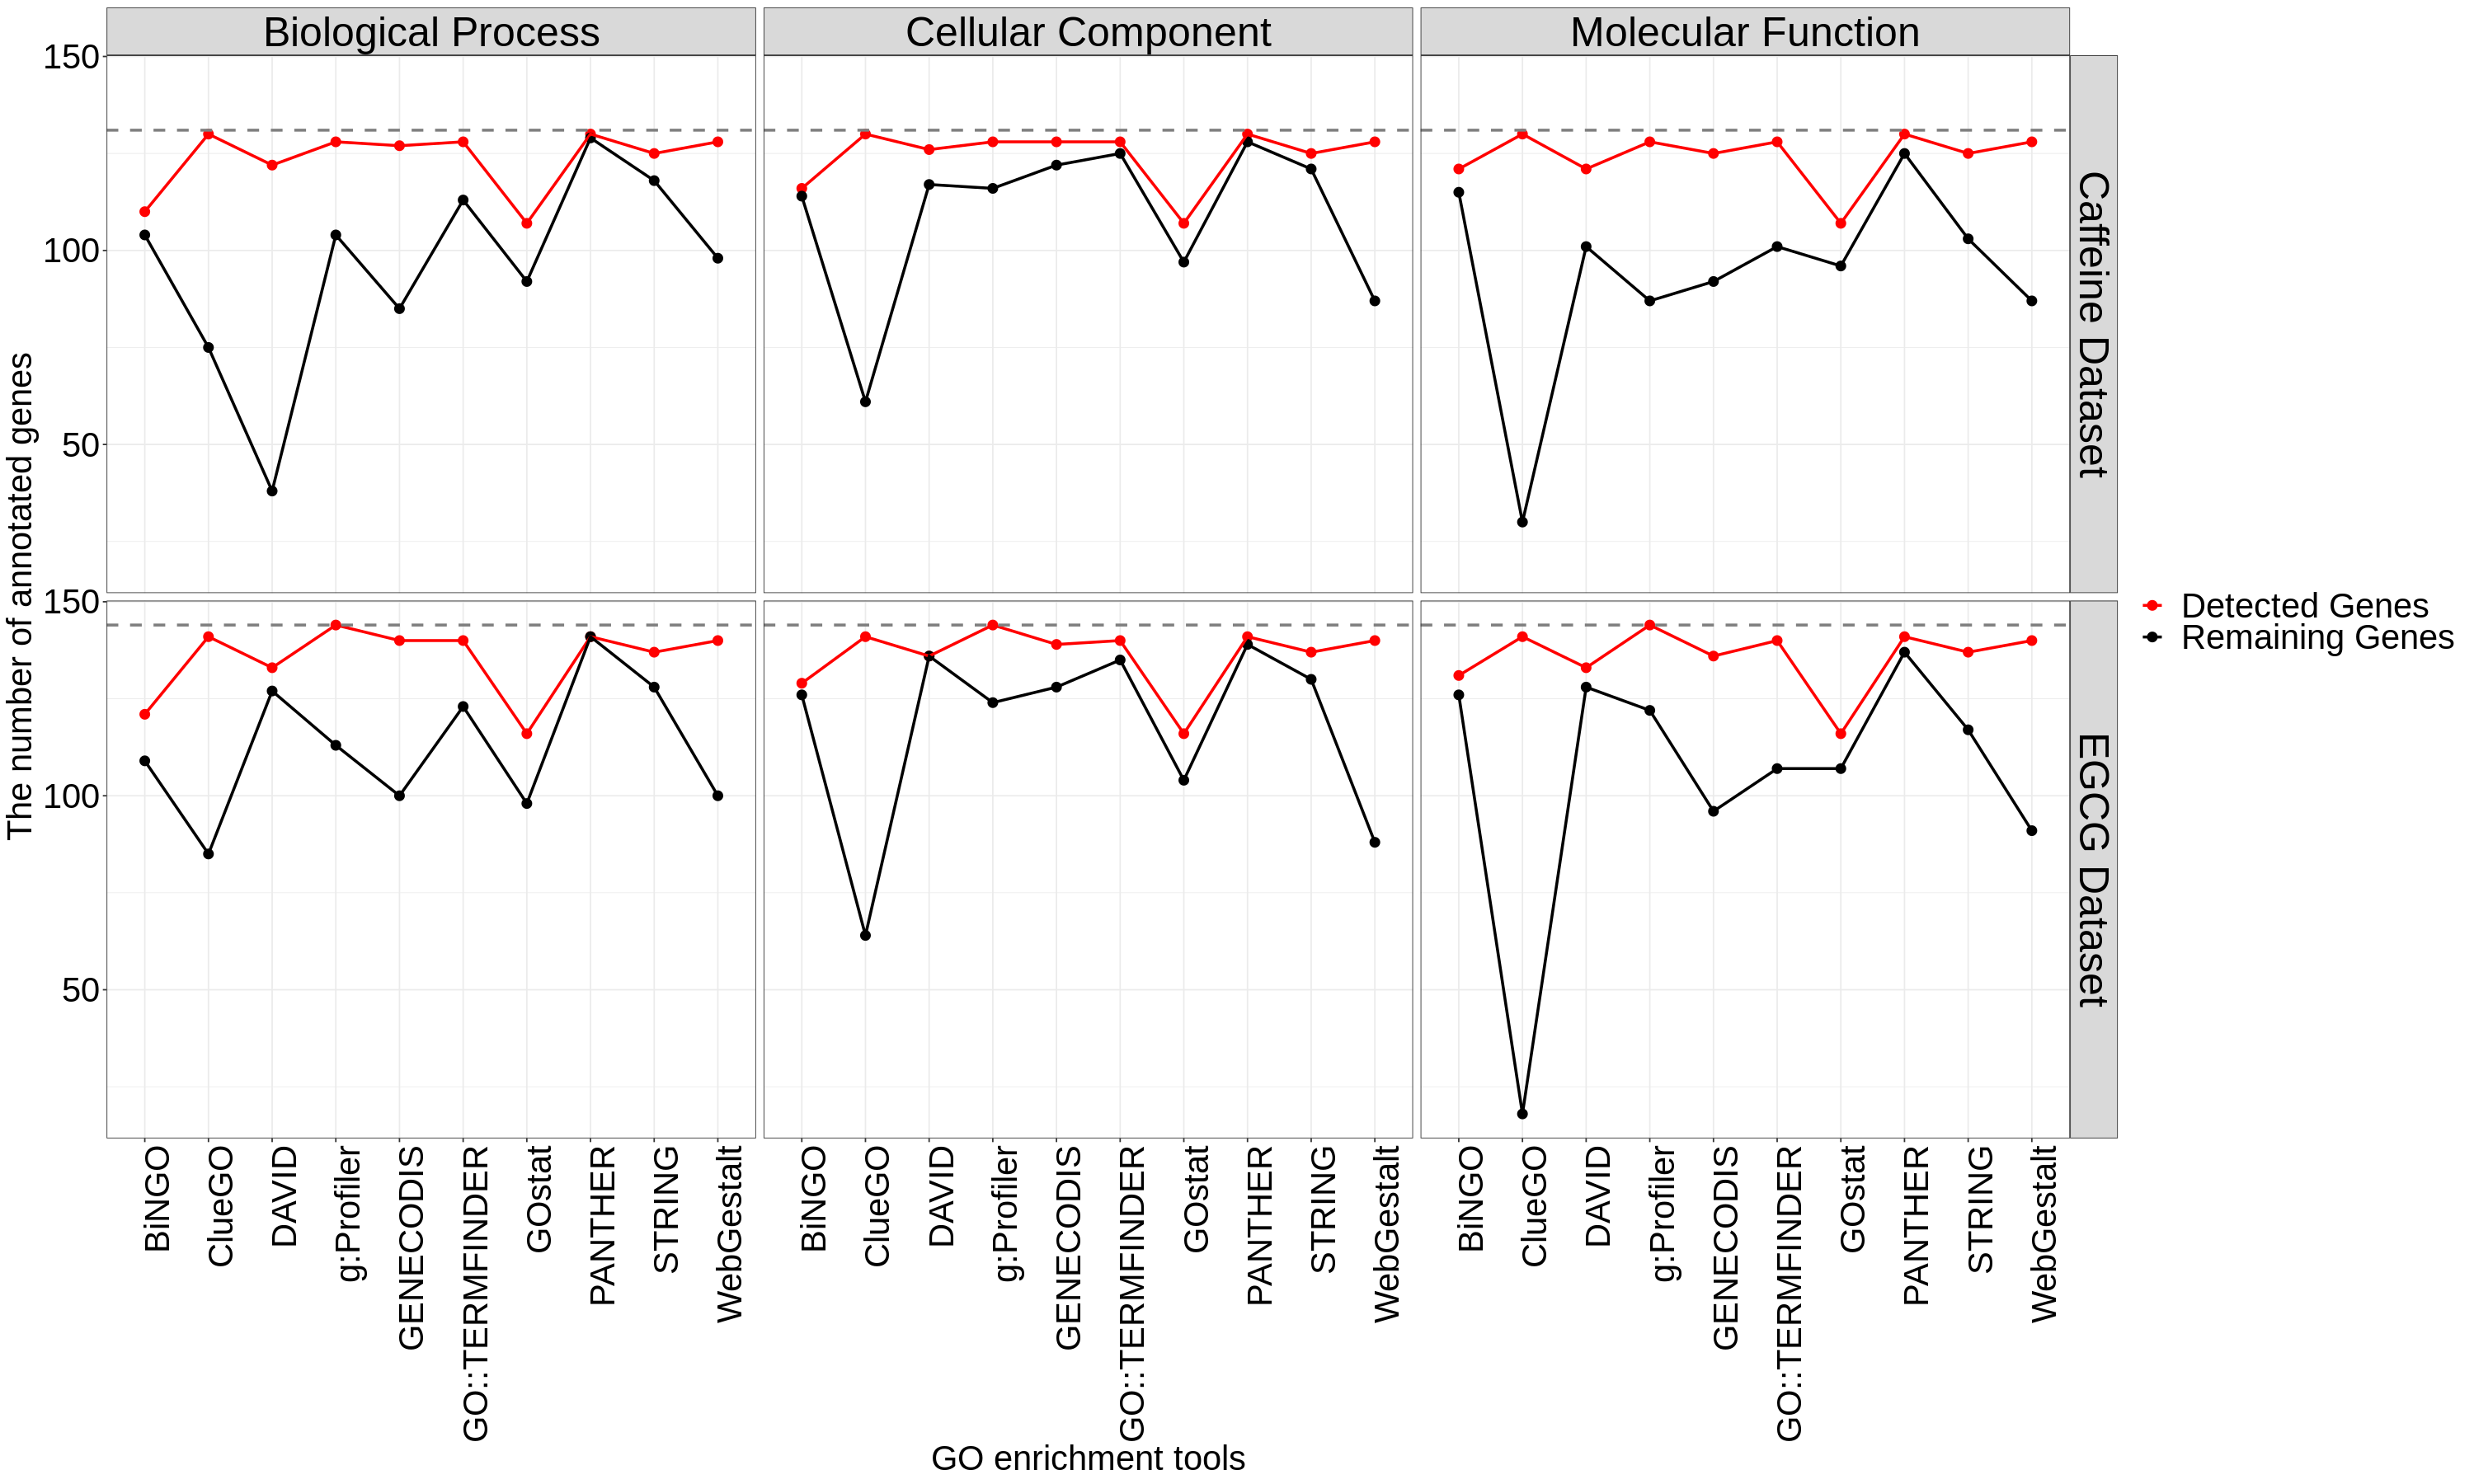

In [65]:
get_annotate <- function(i){
  detected_gene <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Correlation-GOterm-Input.txt") %>% 
  filter(V1 == i)
  detected_gene$cat <- "Annotated Gene"
  names(detected_gene) <- c("dataset","CNT","type","database","cat")
  redf_ca <- df_j %>% filter(dataset==i)
  names(redf_ca) <- c("dataset","database","type","CNT","cat")
  res_annotate <- bind_rows(detected_gene,redf_ca)
  return(res_annotate)
}

res_ca_gene <- get_annotate("Caffeine Dataset")
res_egcg_gene <- get_annotate("EGCG Dataset")

res_gene_all <- rbind(res_ca_gene,res_egcg_gene) 

options(repr.plot.width=25, repr.plot.height=15)

dummy2 <- data.frame(dataset = c("Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset"), 
                     type = c("Biological Process", "Molecular Function","Cellular Component",
                     "Biological Process", "Molecular Function","Cellular Component"),
                     CNT=c(131,131,131,144,144,144))

ggplot(res_gene_all,aes(database,CNT,color=cat,group=cat)) +
geom_point(size=3) +
geom_line(size=1) +
facet_grid(cols=vars(type),rows=vars(dataset)) +
geom_hline(data = dummy2, aes(yintercept = CNT),linetype="dashed",color="grey50",size=1) +
theme_bw() +
font_custom +
scale_color_manual(labels = c("Detected Genes", "Remaining Genes"),values = c("red","black")) +
labs(color="") +
xlab("GO enrichment tools") +
ylab("The number of annotated genes")

#chisq.test(df_j_2$CNT %>% unlist(), 
#            p = c(1/10,1/10,1/10,
#                 1/10,1/10,1/10,
#                 1/10,1/10,1/10,
#                  1/10))


# **The comparison of common vs. unique identified GO terms in the current and previous study**







## summary of GO term uniquess

In [ ]:
uniq_df <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() 
list_df <- table(uniq_df$id) %>% melt() %>% filter(value==1) %>% select(Var1) %>% unlist() 

uniqueness_df <- uniq_df %>% filter(id %in% list_df) %>% group_by(dataset,database,type) %>% summarise(CNT=n()) %>% as.data.frame() %>%
      add_row(database = c("BiNGO","ClueGO","GO::TERMFINDER","GO::TERMFINDER","WebGestalt","g:Profiler","g:Profiler","g:Profiler","DAVID","DAVID","DAVID"),
                   CNT = c(0,0,0,0,0,0,0,0,0,0,0),
                   dataset = c("Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset"),
                  type = c("Molecular Function","Cellular Component","Molecular Function","Cellular Component","Cellular Component","Molecular Function","Cellular Component",
                  "Biological Process","Molecular Function","Cellular Component","Biological Process")) %>%
      add_row(database = c("BiNGO","DAVID","PANTHER","PANTHER","STRING","WebGestalt","WebGestalt","ClueGO","ClueGO","g:Profiler","g:Profiler","g:Profiler",
      "GO::TERMFINDER","GO::TERMFINDER","GO::TERMFINDER"),
                   CNT = c(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),
                   dataset = c("EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset",
                   "EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset"),
                  type = c("Molecular Function","Cellular Component","Molecular Function","Cellular Component",
                  "Cellular Component","Molecular Function","Cellular Component","Molecular Function","Cellular Component","Molecular Function","Cellular Component",
                  "Biological Process","Molecular Function","Cellular Component","Biological Process"))
uniqueness_df_caf <- uniqueness_df %>% filter(dataset == "Caffeine Dataset")
uniqueness_df_caf_02 <- uniqueness_df_caf[order(uniqueness_df_caf$database),]
uniqueness_df_egcg <- uniqueness_df %>% filter(dataset == "EGCG Dataset")
uniqueness_df_egcg_02 <- uniqueness_df_egcg[order(uniqueness_df_egcg$database),]

uniquesness_all <- cbind(uniqueness_df_egcg_02,uniqueness_df_caf_02)
uniquesness_all_02 <- uniquesness_all[,-c(3,5,6)]
names(uniquesness_all_02) <- c("dataset","database","EGCG","type","Caffeine")
uniquesness_all_02$cat <- "Uniquess"
uniqueness_GO <- uniquesness_all_02[,-1]
uniqueness_GO


## Uniquess Visualization

In [ ]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() %>% filter(dataset == "Caffeine Dataset") %>% filter(type == "Biological Process")

pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")

UpSetR::upset(pca_new_03, 
      nsets = 10, 
      order.by = "freq", 
       keep.order = TRUE,
      text.scale = 2, 
      point.size = 3, 
      line.size = 1,
      queries = list(list(query = intersects, params = list("STRING"), active = T,color = "red"),
      list(query = intersects, params = list("BiNGO"), active = T,color = "red"),
      list(query = intersects, params = list("GENECODIS"), active = T,color = "red"),
      list(query = intersects, params = list("GOstat"), active = T,color = "red"),
      list(query = intersects, params = list("PANTHER"), active = T,color = "red"),
      list(query = intersects, params = list("WebGestalt"), active = T,color = "red"),
      list(query = intersects, params = list("ClueGO"), active = T,color = "red"),
      list(query = intersects, params = list("GO::TERMFINDER"), active = T,color = "red")),
      empty.intersections = "on")

pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() %>% filter(dataset == "EGCG Dataset") %>% filter(type == "Biological Process")

pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
pca_new_03_name <- colnames(pca_new_03)[4:13]
UpSetR::upset(pca_new_03, 
      nsets = 10, 
      order.by = "freq", 
       keep.order = TRUE,
      text.scale = 2, 
      point.size = 3, 
      line.size = 1,
      empty.intersections = "on",
      queries = list(list(query = intersects, params = list("STRING"), active = T,color = "red"),
      list(query = intersects, params = list("BiNGO"), active = T,color = "red"),
      list(query = intersects, params = list("GENECODIS"), active = T,color = "red"),
      list(query = intersects, params = list("GOstat"), active = T,color = "red"),
      list(query = intersects, params = list("PANTHER"), active = T,color = "red"),
      list(query = intersects, params = list("WebGestalt"), active = T,color = "red"),
      list(query = intersects, params = list("ClueGO"), active = T,color = "red"),
      list(query = intersects, params = list("DAVID"), active = T,color = "red")))


In [ ]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() %>% filter(dataset == "EGCG Dataset") %>% filter(type == "Cellular Component")

pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
pca_new_03_name <- colnames(pca_new_03)[4:13]
UpSetR::upset(pca_new_03, 
      nsets = 10, 
      order.by = "freq", 
       keep.order = TRUE,
      text.scale = 2, 
      point.size = 3, 
      line.size = 1,
      queries = list(list(query = intersects, params = list("STRING"), active = T,color = "red"),
      list(query = intersects, params = list("BiNGO"), active = T,color = "red"),
      list(query = intersects, params = list("GENECODIS"), active = T,color = "red"),
      list(query = intersects, params = list("GOstat"), active = T,color = "red"),
      list(query = intersects, params = list("PANTHER"), active = T,color = "red"),
      list(query = intersects, params = list("DAVID"), active = T,color = "red")))


pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() %>% filter(dataset == "Caffeine Dataset") %>% filter(type == "Cellular Component")

pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
pca_new_03_name <- colnames(pca_new_03)[4:13]
UpSetR::upset(pca_new_03, 
      nsets = 10, 
      order.by = "freq", 
       keep.order = TRUE,
      text.scale = 2, 
      point.size = 3, 
      line.size = 1,
      queries = list(list(query = intersects, params = list("STRING"), active = T,color = "red"),
      list(query = intersects, params = list("BiNGO"), active = T,color = "red"),
      list(query = intersects, params = list("GENECODIS"), active = T,color = "red"),
      list(query = intersects, params = list("GOstat"), active = T,color = "red"),
      list(query = intersects, params = list("PANTHER"), active = T,color = "red"),
      list(query = intersects, params = list("DAVID"), active = T,color = "red"),
      list(query = intersects, params = list("GO::TERMFINDER"), active = T,color = "red")))





In [ ]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() %>% filter(dataset == "EGCG Dataset") %>% filter(type == "Molecular Function")

pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
pca_new_03_name <- colnames(pca_new_03)[4:13]
UpSetR::upset(pca_new_03, 
      nsets = 10, 
      order.by = "freq", 
       keep.order = TRUE,
      text.scale = 2, 
      point.size = 3, 
      line.size = 1,
      queries = list(list(query = intersects, params = list("STRING"), active = T,color = "red"),
      list(query = intersects, params = list("GENECODIS"), active = T,color = "red"),
      list(query = intersects, params = list("GOstat"), active = T,color = "red"),
      list(query = intersects, params = list("PANTHER"), active = T,color = "red"),
      list(query = intersects, params = list("DAVID"), active = T,color = "red")))

pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() %>% filter(dataset == "Caffeine Dataset") %>% filter(type == "Molecular Function")

pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
pca_new_03_name <- colnames(pca_new_03)[4:13]
UpSetR::upset(pca_new_03, 
      nsets = 10, 
      order.by = "freq", 
       keep.order = TRUE,
      text.scale = 2, 
      point.size = 3, 
      line.size = 1,
      queries = list(list(query = intersects, params = list("STRING"), active = T,color = "red"),
      list(query = intersects, params = list("GENECODIS"), active = T,color = "red"),
      list(query = intersects, params = list("GOstat"), active = T,color = "red"),
      list(query = intersects, params = list("PANTHER"), active = T,color = "red"),
      list(query = intersects, params = list("DAVID"), active = T,color = "red"),
      list(query = intersects, params = list("ClueGO"), active = T,color = "red"),
      list(query = intersects, params = list("WebGestalt"), active = T,color = "red")))


## Variation Within Dataset

### PCA

In [ ]:
pca_cal <- function(j,k){
  pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% dplyr::select(-gene) %>% unique() %>% 
  filter(dataset == j,type == k) %>% select(id,database) %>% unique()
  pca_new_02 <- table(pca_new$database,pca_new$id) %>% as.data.frame()
  pca_new_03 <- reshape(pca_new_02, idvar = "Var1", timevar = "Var2", direction = "wide")
  pca_new_04 <- pca_new_03[,-1]
  rownames(pca_new_04) <- pca_new_03[,1]
  pca_new_05 <- prcomp(pca_new_04)$x %>% as.data.frame() %>% select(PC1,PC2)
  pca_new_05$dataset <- j
  pca_new_05$type <- k
  options(repr.plot.width=10, repr.plot.height=10)
  ggplot(pca_new_05,aes(PC1,PC2)) + geom_point(size=4) + geom_label_repel(label=rownames(pca_new_05),size = 6)  + theme_bw() + font_custom + xlab("1st PCs") + ylab("2nd PCs")
}

In [ ]:
#pca_cal("EGCG Dataset","Biological Process")
#pca_cal("EGCG Dataset","Molecular Function")
#pca_cal("EGCG Dataset","Cellular Component")
#pca_cal("Caffeine Dataset","Biological Process")
#pca_cal("Caffeine Dataset","Molecular Function")
#pca_cal("Caffeine Dataset","Cellular Component")

### K-Mean

In [ ]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt",header=TRUE) %>% dplyr::select(-gene) %>% unique() %>% 
filter(dataset == "Caffeine Dataset",type == "Molecular Function") %>% select(id,database) %>% unique()
pca_new_02 <- table(pca_new$database,pca_new$id) %>% as.data.frame()
pca_new_03 <- reshape(pca_new_02, idvar = "Var1", timevar = "Var2", direction = "wide")
pca_new_04 <- pca_new_03[,-1]
rownames(pca_new_04) <- pca_new_03[,1]
df_pre <- pca_new_04
#install.packages("caret")
#library(caret)
#library (cluster)
nzv <- nearZeroVar(df_pre)
filtered_df <- df_pre[, -nzv]
df <- filtered_df

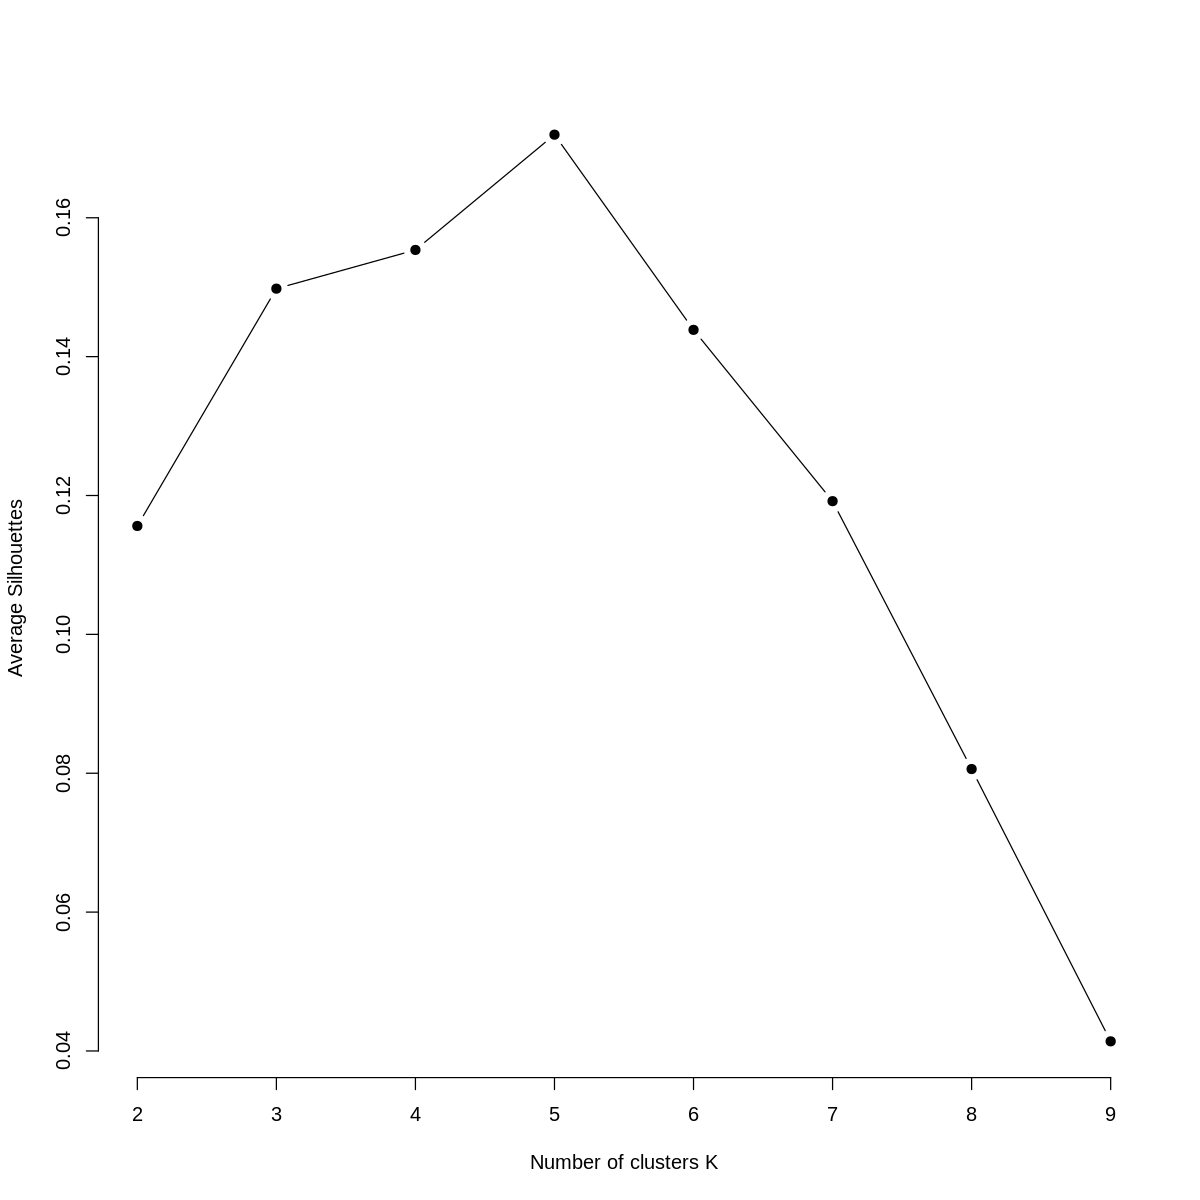

In [ ]:
set.seed(123)

# function to compute average silhouette for k clusters
avg_sil <- function(k) {
  km.res <- kmeans(df, centers = k, nstart = 50)
  ss <- silhouette(km.res$cluster, dist(df))
  mean(ss[, 3])
}

k.values <- 2:9

# extract avg silhouette for 2-15 clusters
avg_sil_values <- map_dbl(k.values, avg_sil)

plot(k.values, avg_sil_values,
       type = "b", pch = 19, frame = FALSE, 
       xlab = "Number of clusters K",
       ylab = "Average Silhouettes")


final <- kmeans(df,5, nstart = 50,iter.max = 100)


In [ ]:
# Make plots wider 
options(repr.plot.width=10, repr.plot.height=10)
fviz_cluster(final, data = df,labelsize = 16,ellipse = T,show.clust.cent = T,repel=T,
pointsize = 4,ggtheme = theme_bw()) +
  theme_bw() +xlim(-29,15) + xlab("1st PCs (22.8 %)") + ylab("2nd PCs (19.3 %)") + font_custom.02

# New Section

In [ ]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% dplyr::select(-gene) %>% unique()  
pca_new_02 <- table(pca_new$database,pca_new$id,pca_new$dataset,pca_new$type) %>% as.data.frame()
pca_new_03 <- reshape(pca_new_02, idvar = c("Var1","Var3","Var4"), timevar = "Var2", direction = "wide")

Kappa_between <- function(database,categories){
  chi <- pca_new_03 %>% filter(Var3 == database, Var4 == categories) %>% select(-Var3,-Var4) 
  chi.01 <- chi[,-1]
  rownames(chi.01) <- chi[,1]
  chi.01[chi.01 > 1]<-1
  ex <-  chi.01 %>% t() %>% as.data.frame()
  out <- as.data.frame(matrix(0, nrow = 1, ncol = ncol(ex) * (ncol(ex)-1) / 2))
  column <- 1

  # cycle for calculation kappa
for (i in 1:(ncol(ex)-1)){
  for (j in (i+1):ncol(ex)){
    out[1,column] <- irr::kappa2(ex[,c(i,j)])$value
    colnames(out)[column] <- paste(colnames(ex[i]), 
                                      "&", colnames(ex[j]))
    column <- column + 1
  }
}
res <- t(out) %>% as.data.frame() 
res$categories <- categories
res$databases <- database
res
}


In [ ]:
EGCG.BP <- Kappa_between("EGCG Dataset","Biological Process")
EGCG.MF <- Kappa_between("EGCG Dataset","Molecular Function")
EGCG.CC <- Kappa_between("EGCG Dataset","Cellular Component")

Caf.BP <- Kappa_between("Caffeine Dataset","Biological Process")
Caf.MF <- Kappa_between("Caffeine Dataset","Molecular Function")
Caf.CC <- Kappa_between("Caffeine Dataset","Cellular Component")

cdf_EGCG_validate <- rbind(EGCG.BP,EGCG.MF,EGCG.CC)
cdf_caffeine_validate <- rbind(Caf.BP,Caf.MF,Caf.CC)
cdf_validate <- cbind(cdf_EGCG_validate,cdf_caffeine_validate)
cdf_validate.02 <- cdf_validate[,-c(2,3,6)] 
names(cdf_validate.02) <- c("EGCG Dataset","Caffeine Dataset","Categories")

Using Categories as id variables



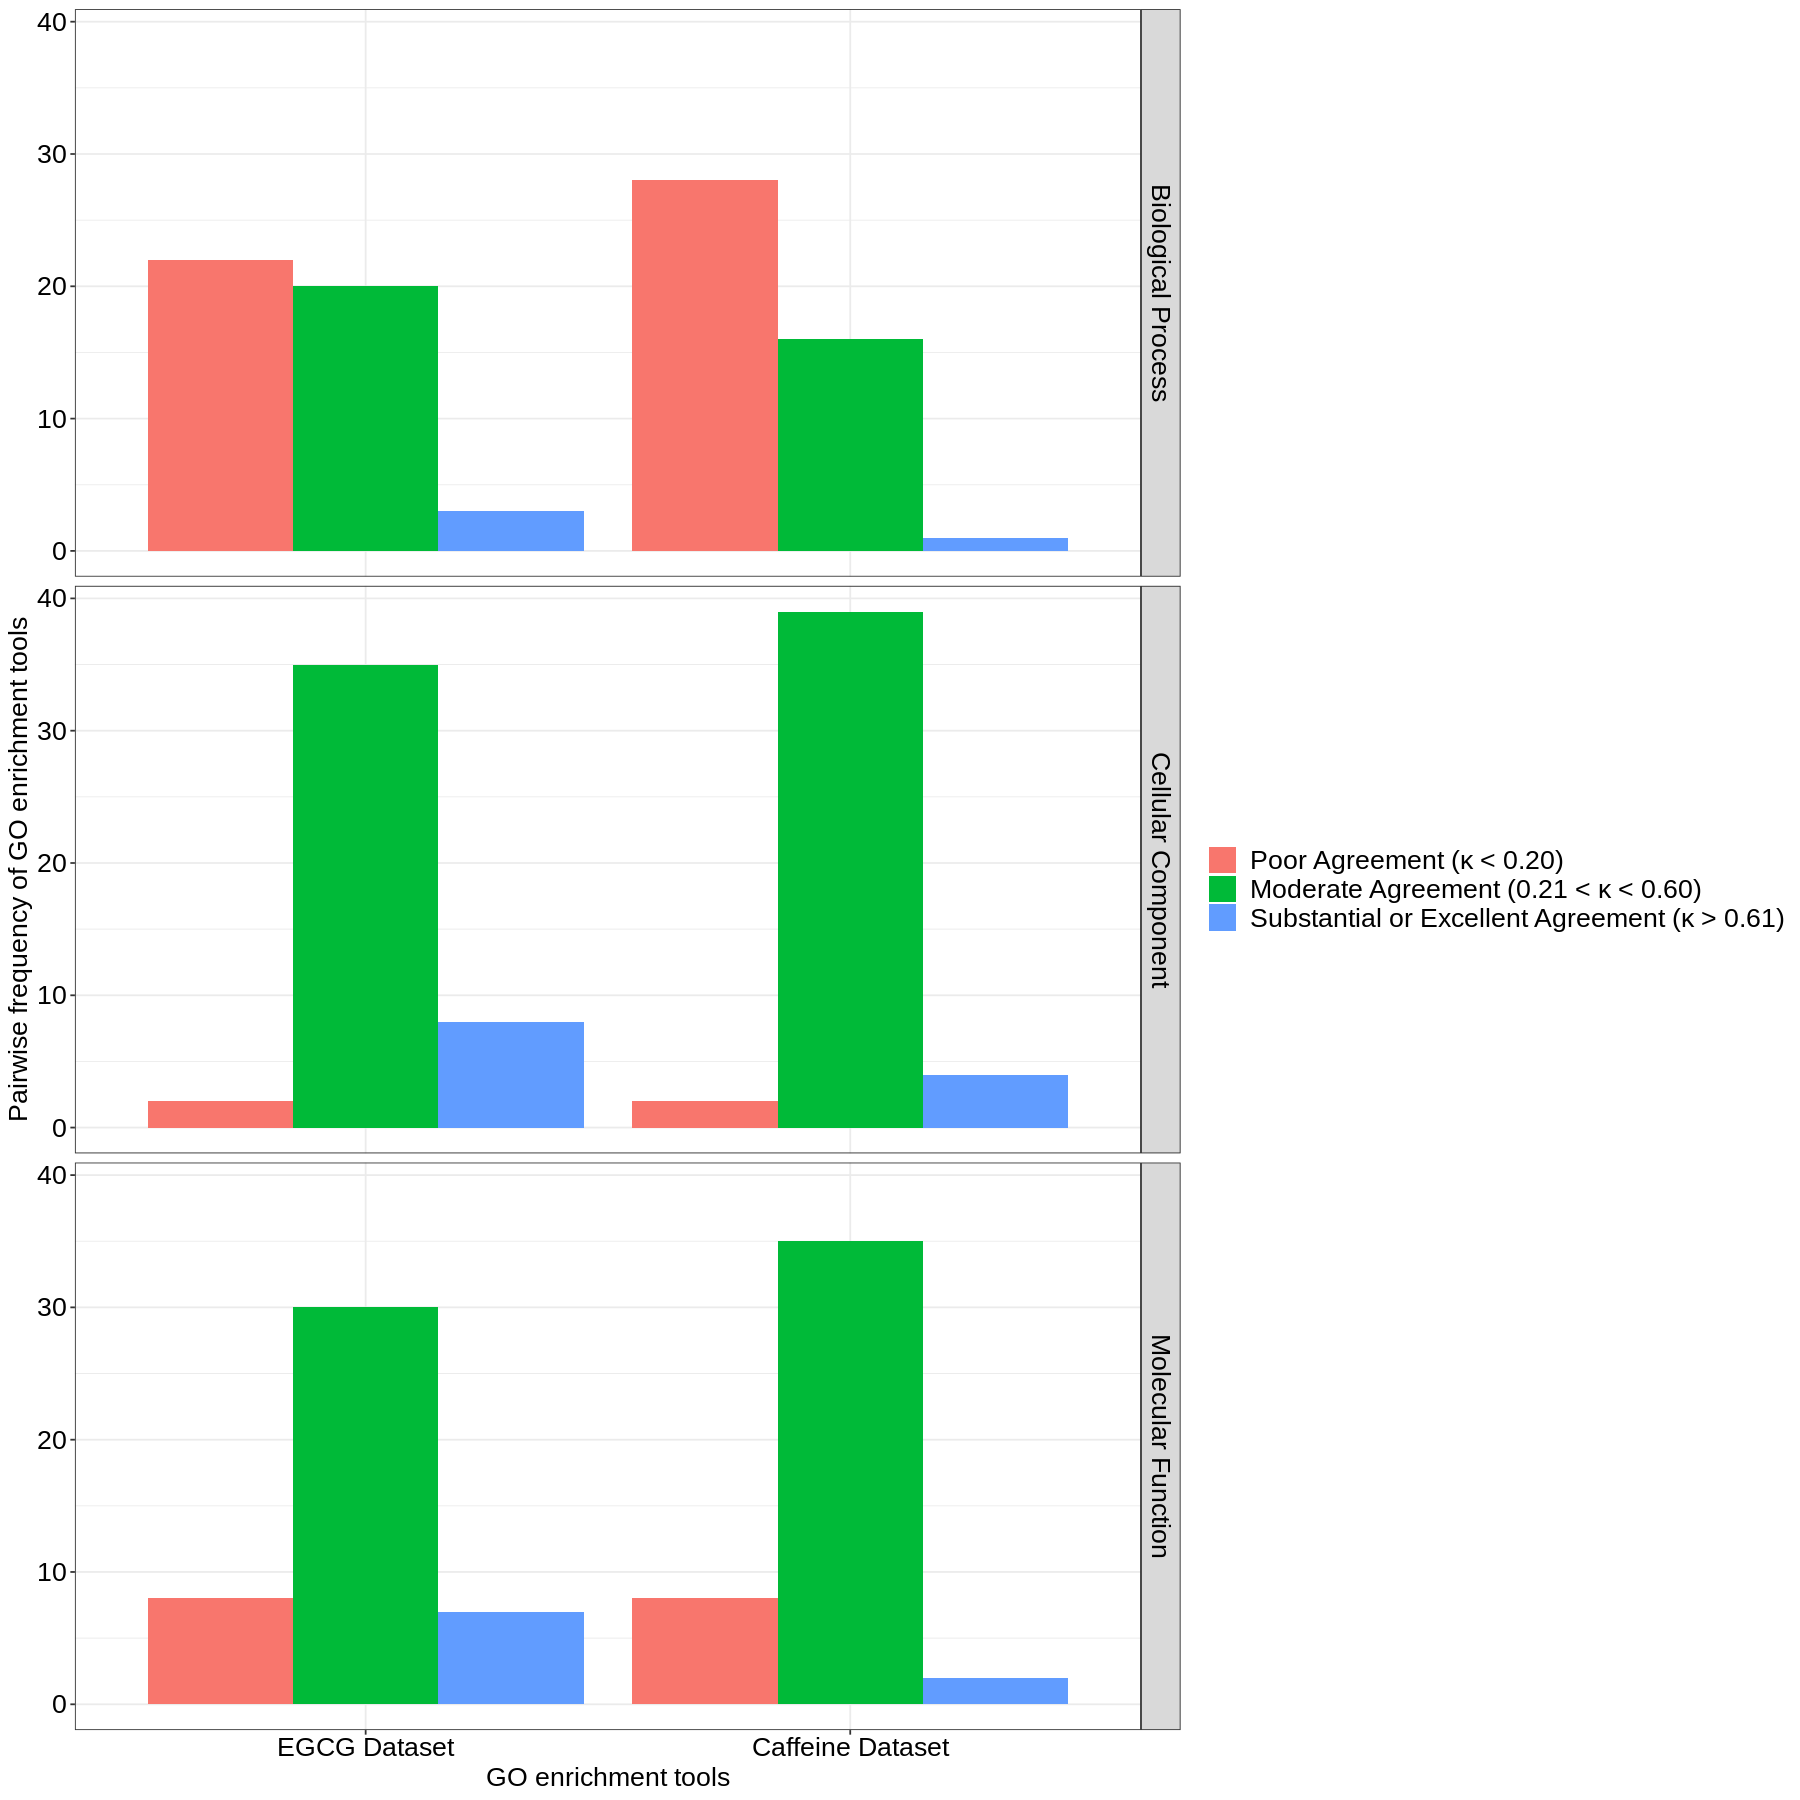

In [ ]:
cdf_validate.02 <- cdf_validate.02 %>% melt() 
cdf_validate.02$con <-  ifelse(cdf_validate.02$value > 0.61, "Substantial or Excellent Agreement (κ > 0.61)",
ifelse(cdf_validate.02$value < 0.21,"Poor Agreement (κ < 0.20)","Moderate Agreement (0.21 < κ < 0.60)"))


cdf_validate.03 <- table(cdf_validate.02$con,cdf_validate.02$Categories,cdf_validate.02$variable) %>% melt()

cdf_validate.03$Var1 <- factor(cdf_validate.03$Var1, levels = c("Poor Agreement (κ < 0.20)",
                                                              "Moderate Agreement (0.21 < κ < 0.60)",
                                                               "Substantial or Excellent Agreement (κ > 0.61)"))


ggplot(cdf_validate.03, aes(x=Var3, y=value,fill=Var1)) + 
  geom_bar(stat = "identity", position = position_dodge()) +
  facet_grid(rows=vars(Var2)) +
  theme_bw() +
  font_custom.02 +
  labs(fill="")+
  xlab("GO enrichment tools") +
  ylab("Pairwise frequency of GO enrichment tools")

#Information Content

## summary of GO term IC

In [ ]:
all_IC <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% dplyr::select(-gene) %>% unique() 
head(all_IC)

In [ ]:
P <- toTable(GOBPOFFSPRING)
names(P) <- c("child","parent")
P_count <- as.data.frame(table(P$parent))
P_count$type <- "BP"

C <- toTable(GOCCOFFSPRING)
names(C) <- c("child","parent")
C_count <- as.data.frame(table(C$parent))
C_count$type <- "CC"

M <- toTable(GOMFOFFSPRING) 
names(M) <- c("child","parent") 
M_count <- as.data.frame(table(M$parent))
M_count$type <- "MF"

ref <- rbind(M_count,C_count,P_count)


IC <- function(id,onto){
  cnt <- dplyr::filter(ref, Var1 == i) %>% dplyr::select(Freq) %>% as.numeric()
  df <- AnnotationDbi::select(GO.db, keys(GO.db, "GOID"),  columns = c("ONTOLOGY"))
  df_02 <- as.data.frame(table(df$ONTOLOGY)) %>% dplyr::filter(.,Var1 == onto) 
  all_onto <- as.numeric(df_02[,2])
  if (is.na(cnt) == T) {
    #all GO term in select ontology
    prob <- 1/all_onto
    IC <- -log2(prob)
    return(IC)
  } else {
   prob <- (cnt+1)/all_onto
    IC <- -log2(prob)
    return(IC)
  }
}

In [ ]:
list <- all_IC %>% dplyr::filter(type == "Molecular Function") %>% dplyr::select(id) %>% unlist() %>% unique() 
datalist <- list()
for (i in list) {
  res <- as.data.frame(IC(i,"MF")) 
  res$i <- i
  datalist[[i]] <- res
}

big_data_MF <- do.call(rbind,datalist) %>% as.data.frame() %>% setnames("i","id")
names(big_data_MF) <- c("IC","id")


In [ ]:
list <- all_IC %>% dplyr::filter(type == "Cellular Component") %>% dplyr::select(id) %>% unlist() %>% unique() 
datalist <- list()
for (i in list) {
  res <- as.data.frame(IC(i,"CC")) 
  res$i <- i
  datalist[[i]] <- res
}

big_data_CC <- do.call(rbind,datalist) %>% as.data.frame() %>% setnames("i","id")  
names(big_data_CC) <- c("IC","id")

In [ ]:
list <- all_IC %>% dplyr::filter(type == "Biological Process") %>% dplyr::select(id) %>% unlist() %>% unique() 
datalist <- list()
for (i in list) {
  res <- as.data.frame(IC(i,"BP")) 
  res$i <- i
  datalist[[i]] <- res
}

big_data_BP <- do.call(rbind,datalist) %>% as.data.frame() %>% setnames("i","id")
names(big_data_BP) <- c("IC","id")

In [ ]:
names(big_data_BP) <- c("IC","id")
names(big_data_CC) <- c("IC","id")
names(big_data_MF) <- c("IC","id")
IC <- rbind(big_data_BP,big_data_CC,big_data_MF) %>% setnames(c("IC","id"),c("IC","id"))

merge_01 <- inner_join(all_IC,IC,by= "id")
merge_01$IC <- as.numeric(merge_01$IC)
merge_02 <- merge_01 %>% setnames("IC","Information_Content")

merge_EGCG <- merge_02 %>%
  group_by(database,type,dataset) %>% 
  dplyr::summarize(median(Information_Content)) %>% 
  as.data.frame() %>% 
  filter(.,dataset == "EGCG Dataset")

merge_Caffeine <- merge_02  %>%
  group_by(database,type,dataset) %>% 
  dplyr::summarize(median(Information_Content)) %>% 
  as.data.frame() %>% 
  filter(.,dataset == "Caffeine Dataset")

In [ ]:
IC_sum <-cbind(merge_Caffeine,merge_EGCG) 
IC_sum_02 <- IC_sum[,c(1,3,4,6,8)]
names(IC_sum_02) <- c("database","dataset","Caffeine","type","EGCG")
IC_sum_02$cat <- "IC median"
IC_all <- IC_sum_02[,-2]

## IC Visualization

Warning message:
“The input is a data frame, convert it to the matrix.”


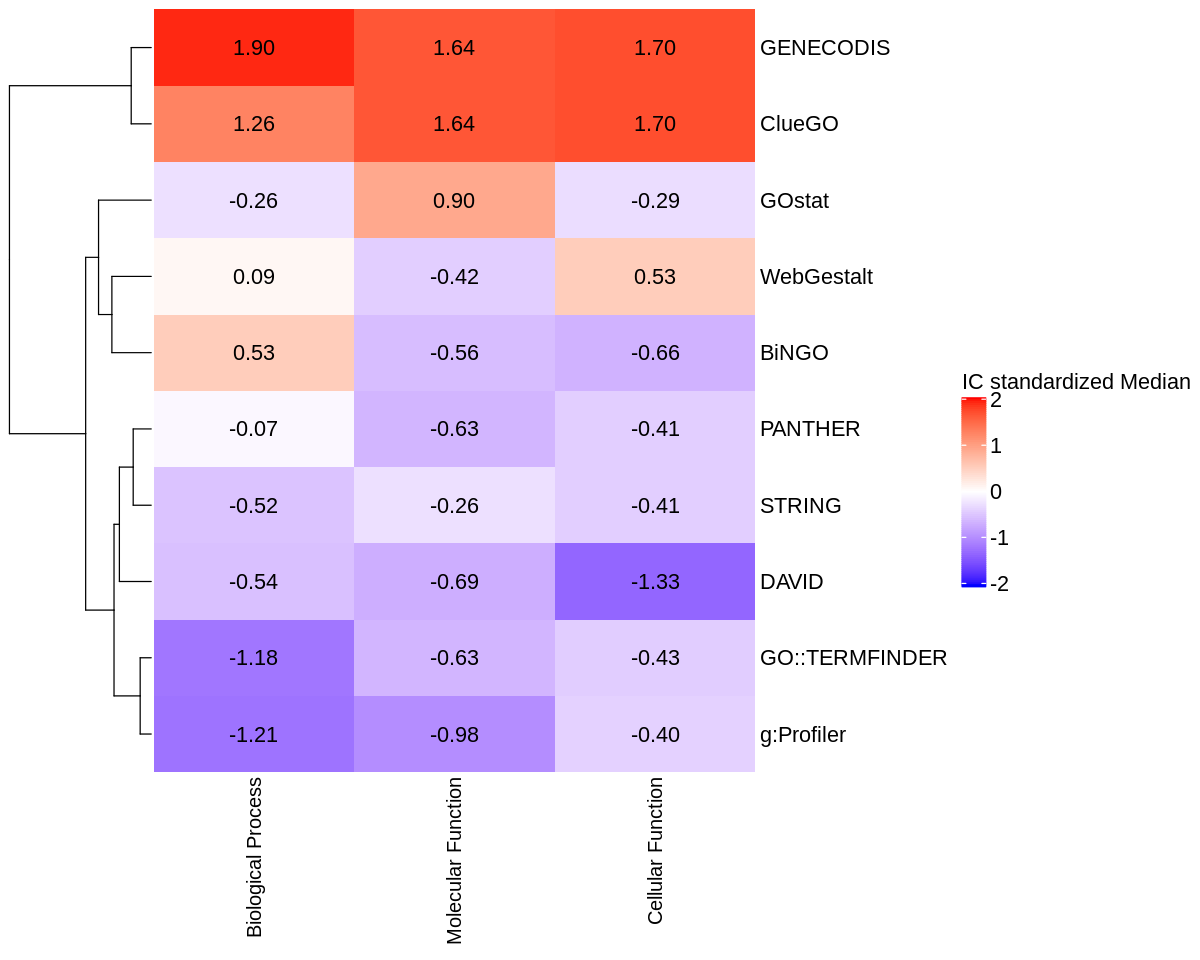

In [ ]:
#EGCG Dataset
EGCG_cor <- reshape(merge_EGCG[,-3],idvar = c("database"),timevar = "type",direction = "wide")
names(EGCG_cor) <- c("database",
              "Biological Process",
              "Cellular Component",
              "Molecular Function")
      
EGCG_cor.01 <- EGCG_cor[,-1]
rownames(EGCG_cor.01) <- EGCG_cor[,1]
EGCG_cor.01$BP <- scale(EGCG_cor.01$`Biological Process`)
EGCG_cor.01$MF <- scale(EGCG_cor.01$`Molecular Function`)
EGCG_cor.01$CC <- scale(EGCG_cor.01$`Cellular Component`)

EGCG_cor.02 <- EGCG_cor.01[,-c(1:3)]
names(EGCG_cor.02) <- c("Biological Process","Molecular Function","Cellular Function")

options(repr.plot.width=10, repr.plot.height=8)
col_fun = circlize::colorRamp2(c(-2, 0, 2), c("blue", "white", "red"))

Heatmap(EGCG_cor.02,col=col_fun, name = "IC standardized Median", 
        row_names_gp = gpar(fontsize = 13),
        heatmap_legend_param = list(
          legend_height = unit(4, "cm"),
          grid_width = unit(0.5, "cm"),
         title_gp = gpar(fontsize = 13),
         labels_gp = gpar(fontsize = 13)),
        row_dend_width = unit(3, "cm"), 
       cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2f", EGCG_cor.02[i, j]), x, y, gp = gpar(fontsize = 13))
        }, clustering_method_rows = "complete",
        cluster_columns = FALSE)


Warning message:
“The input is a data frame, convert it to the matrix.”


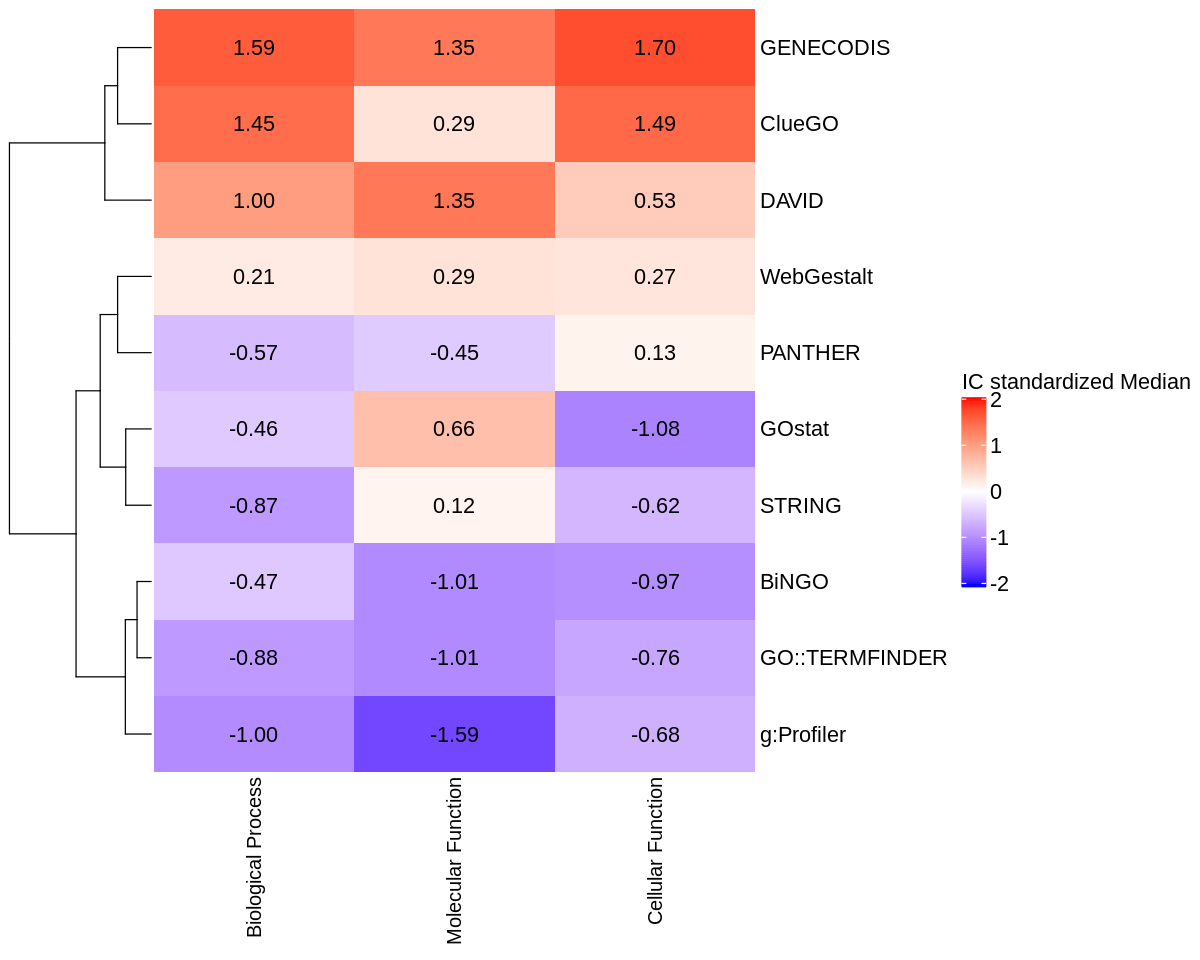

In [ ]:
#Caffeine
Caf_cor <- reshape(merge_Caffeine[,-3],idvar = c("database"),timevar = "type",direction = "wide")
names(Caf_cor) <- c("database",
              "Biological Process",
              "Cellular Component",
              "Molecular Function")
Caf_cor.01 <- Caf_cor[,-1]
rownames(Caf_cor.01) <- Caf_cor[,1]
Caf_cor.01$BP <- scale(Caf_cor.01$`Biological Process`)
Caf_cor.01$MF <- scale(Caf_cor.01$`Molecular Function`)
Caf_cor.01$CC <- scale(Caf_cor.01$`Cellular Component`)
Caf_cor.02 <- Caf_cor.01[,-c(1:3)]
names(Caf_cor.02) <- c("Biological Process","Molecular Function","Cellular Function")

Heatmap(Caf_cor.02,col=col_fun, name = "IC standardized Median", 
        row_names_gp = gpar(fontsize = 13),
        heatmap_legend_param = list(
          legend_height = unit(4, "cm"),
          grid_width = unit(0.5, "cm"),
         title_gp = gpar(fontsize = 13),
         labels_gp = gpar(fontsize = 13)),
        row_dend_width = unit(3, "cm"),
       cluster_columns = FALSE, 
       cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2f", Caf_cor.02[i, j]), x, y, gp = gpar(fontsize = 13))
        }, clustering_method_rows = "complete")

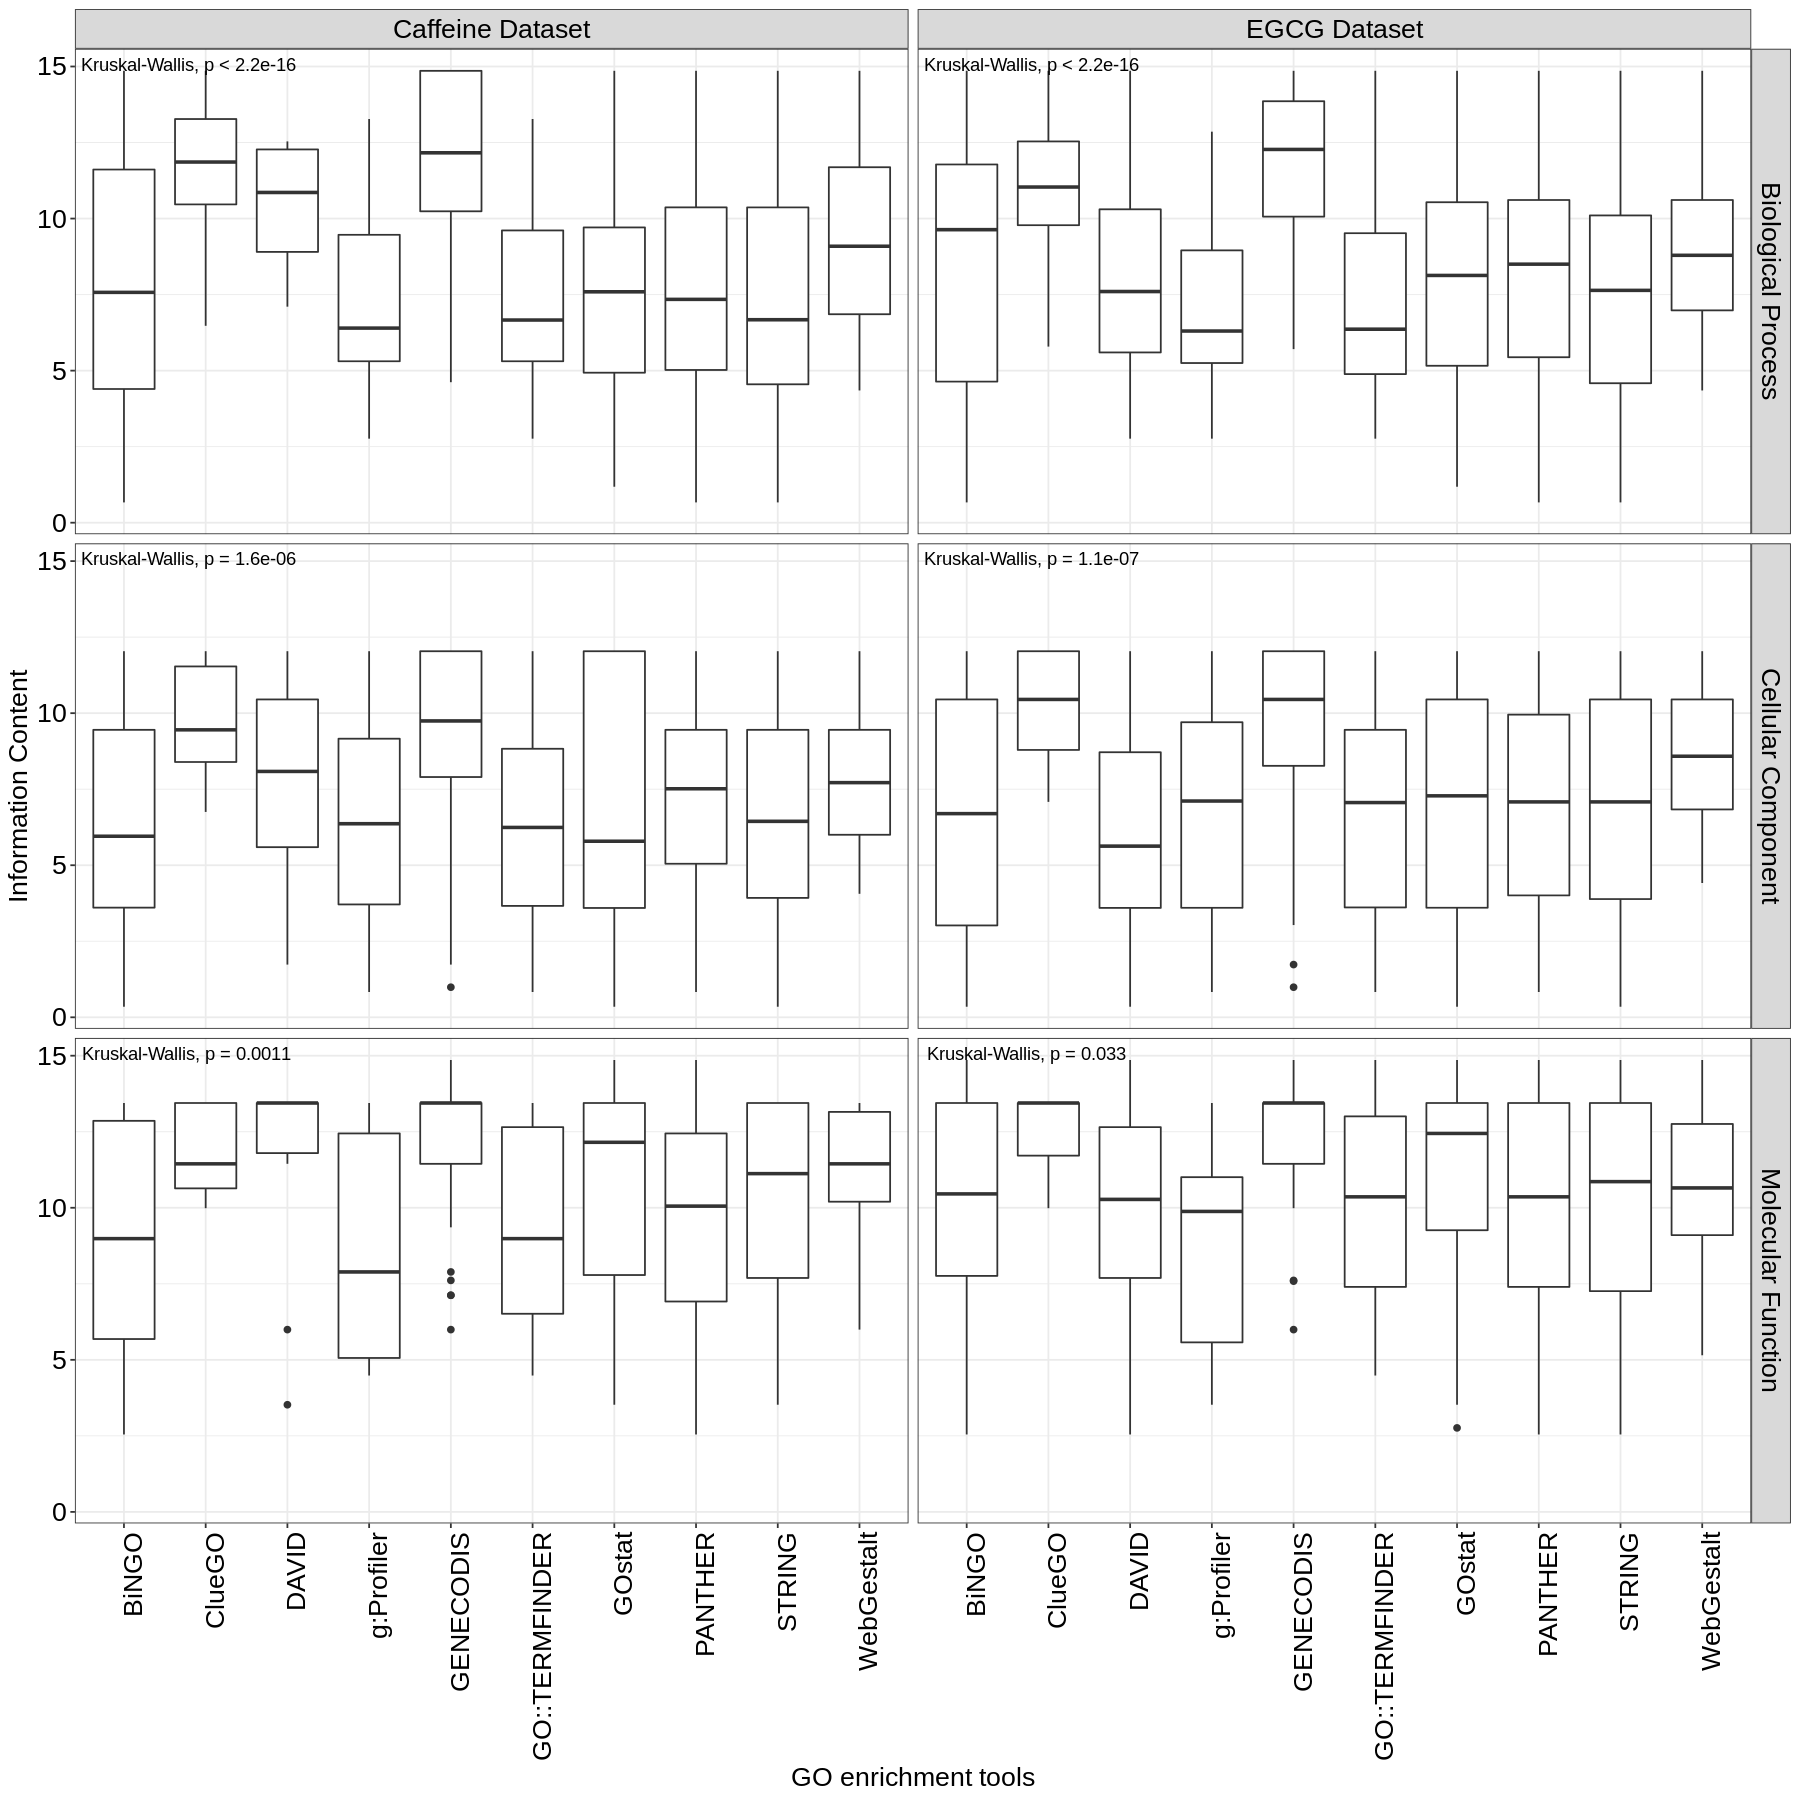

In [ ]:
options(repr.plot.width=15, repr.plot.height=15)
ggplot(merge_02,aes(database,Information_Content)) + geom_boxplot() + 
facet_grid(rows=vars(type),cols=vars(dataset)) + 
theme_bw() +
font_custom +
stat_compare_means() +
xlab("GO enrichment tools") +
ylab("Information Content")

In [ ]:
IC_df <- merge_02[,c(4,5,6,7,9)]
all.IC.index <- IC_df %>% select(type,dataset) %>% unique()

In [ ]:
datalist <- list()
for (i in 1:nrow(all.IC.index)) {
all.test.01 <- IC_df %>% filter(.,type == all.IC.index[i,1] %>% unlist(),
                                            dataset == all.IC.index[i,2] %>% unlist())
res.aov <- kruskal.test(Information_Content ~ database, data = all.test.01)
res.1 <- tidy(res.aov)
res.1$type <- all.IC.index[i,1] %>% unlist()
res.1$dataset <-all.IC.index[i,2] %>% unlist()

PT = dunnTest(Information_Content ~ database,
              data=all.test.01,
              method="none")    

PT.02 <- PT$res %>% select(Comparison,P.adj) %>% as.data.frame() 
PT.03 <- PT.02 
rownames(PT.03) <- PT.02[,1]
PT.04 <- t(PT.03) %>% as.data.frame()
rownames(PT.04) <- NULL
res <- cbind(res.1,PT.04[-1,])
datalist[[i]] <- res
}
res.01 <- do.call(rbind,datalist) %>% unique() %>% as.data.frame() %>% select(-statistic,-parameter,) %>% setnames("p.value","All")
res.02 <- melt(data = res.01, id.vars = c("method", "type","dataset"))
res.02

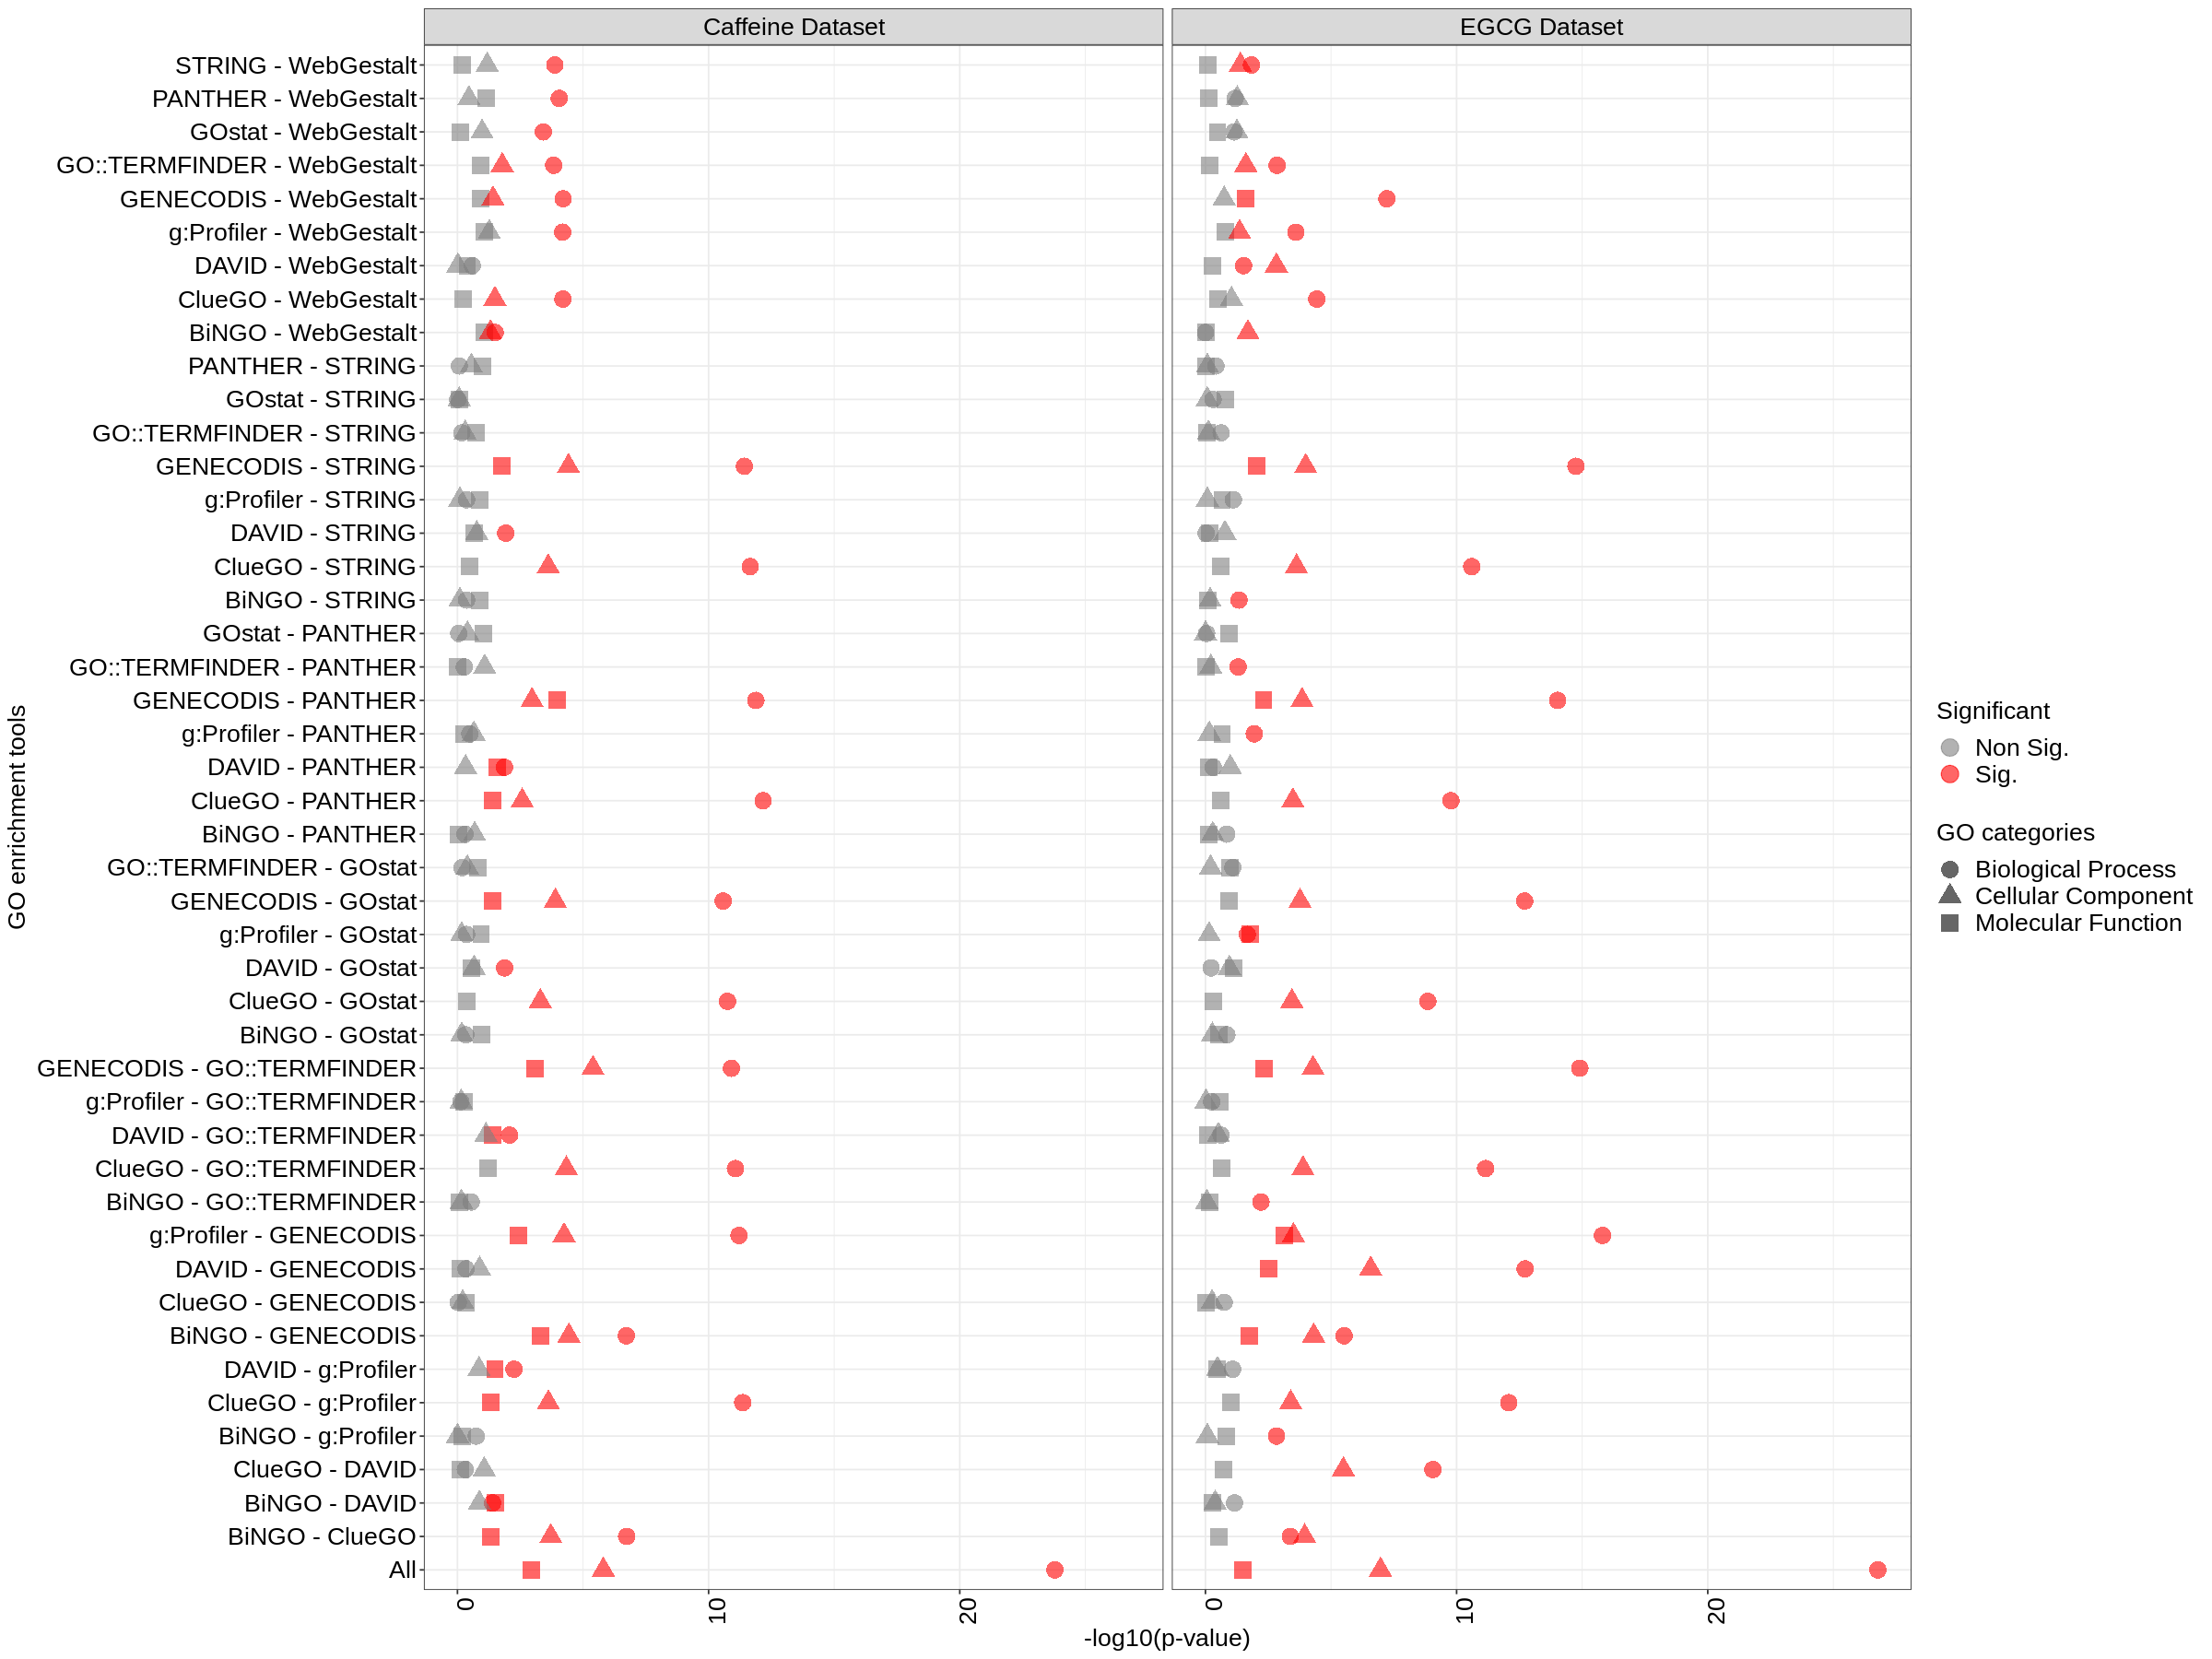

In [ ]:
options(repr.plot.width=20, repr.plot.height=15)
res.03 <- res.02 
res.03$value <- as.numeric(res.03$value)
res.03$con <- ifelse(res.03$value < 0.05,"Sig.","Non Sig.")
res.03$value_02 <- -log10(res.03$value)

res.03 %>% ggplot(aes(variable,value_02,color=con,shape=type)) + geom_point(size=5,alpha=0.6)  +
scale_color_manual(values = c("Non Sig." = "grey50", "Sig." = "red")) + 
facet_grid(cols=vars(dataset)) +
theme_bw() +
font_custom +
coord_flip() +
xlab("GO enrichment tools") +
ylab("-log10(p-value)") +
labs(shape="GO categories", color="Significant")

# **p-value distribution of identified GO terms**

## summary of GO term p-value

In [ ]:
pvalue_tools <- df_01[,c(3,6,7,8)] %>% unique() %>% group_by(type,dataset,database) %>% summarise(MED=median(fdr)) 
pvalue_tools$MED <- -log10(pvalue_tools$MED)
pvalue_Caf <- pvalue_tools %>% filter(dataset == "Caffeine Dataset")
pvalue_EGCG <- pvalue_tools %>% filter(dataset == "EGCG Dataset")
pvalue_all <- cbind(pvalue_Caf,pvalue_EGCG)
pvalue_all_02 <- pvalue_all[,-c(5,6,7)]
names(pvalue_all_02) <- c("type","dataset","database","Caffeine","EGCG")
pvalue_all_02$cat <- "Me p-value"
pvalue_all_final <- pvalue_all_02[,-2]
pvalue_all_final

## Variation Within Dataset

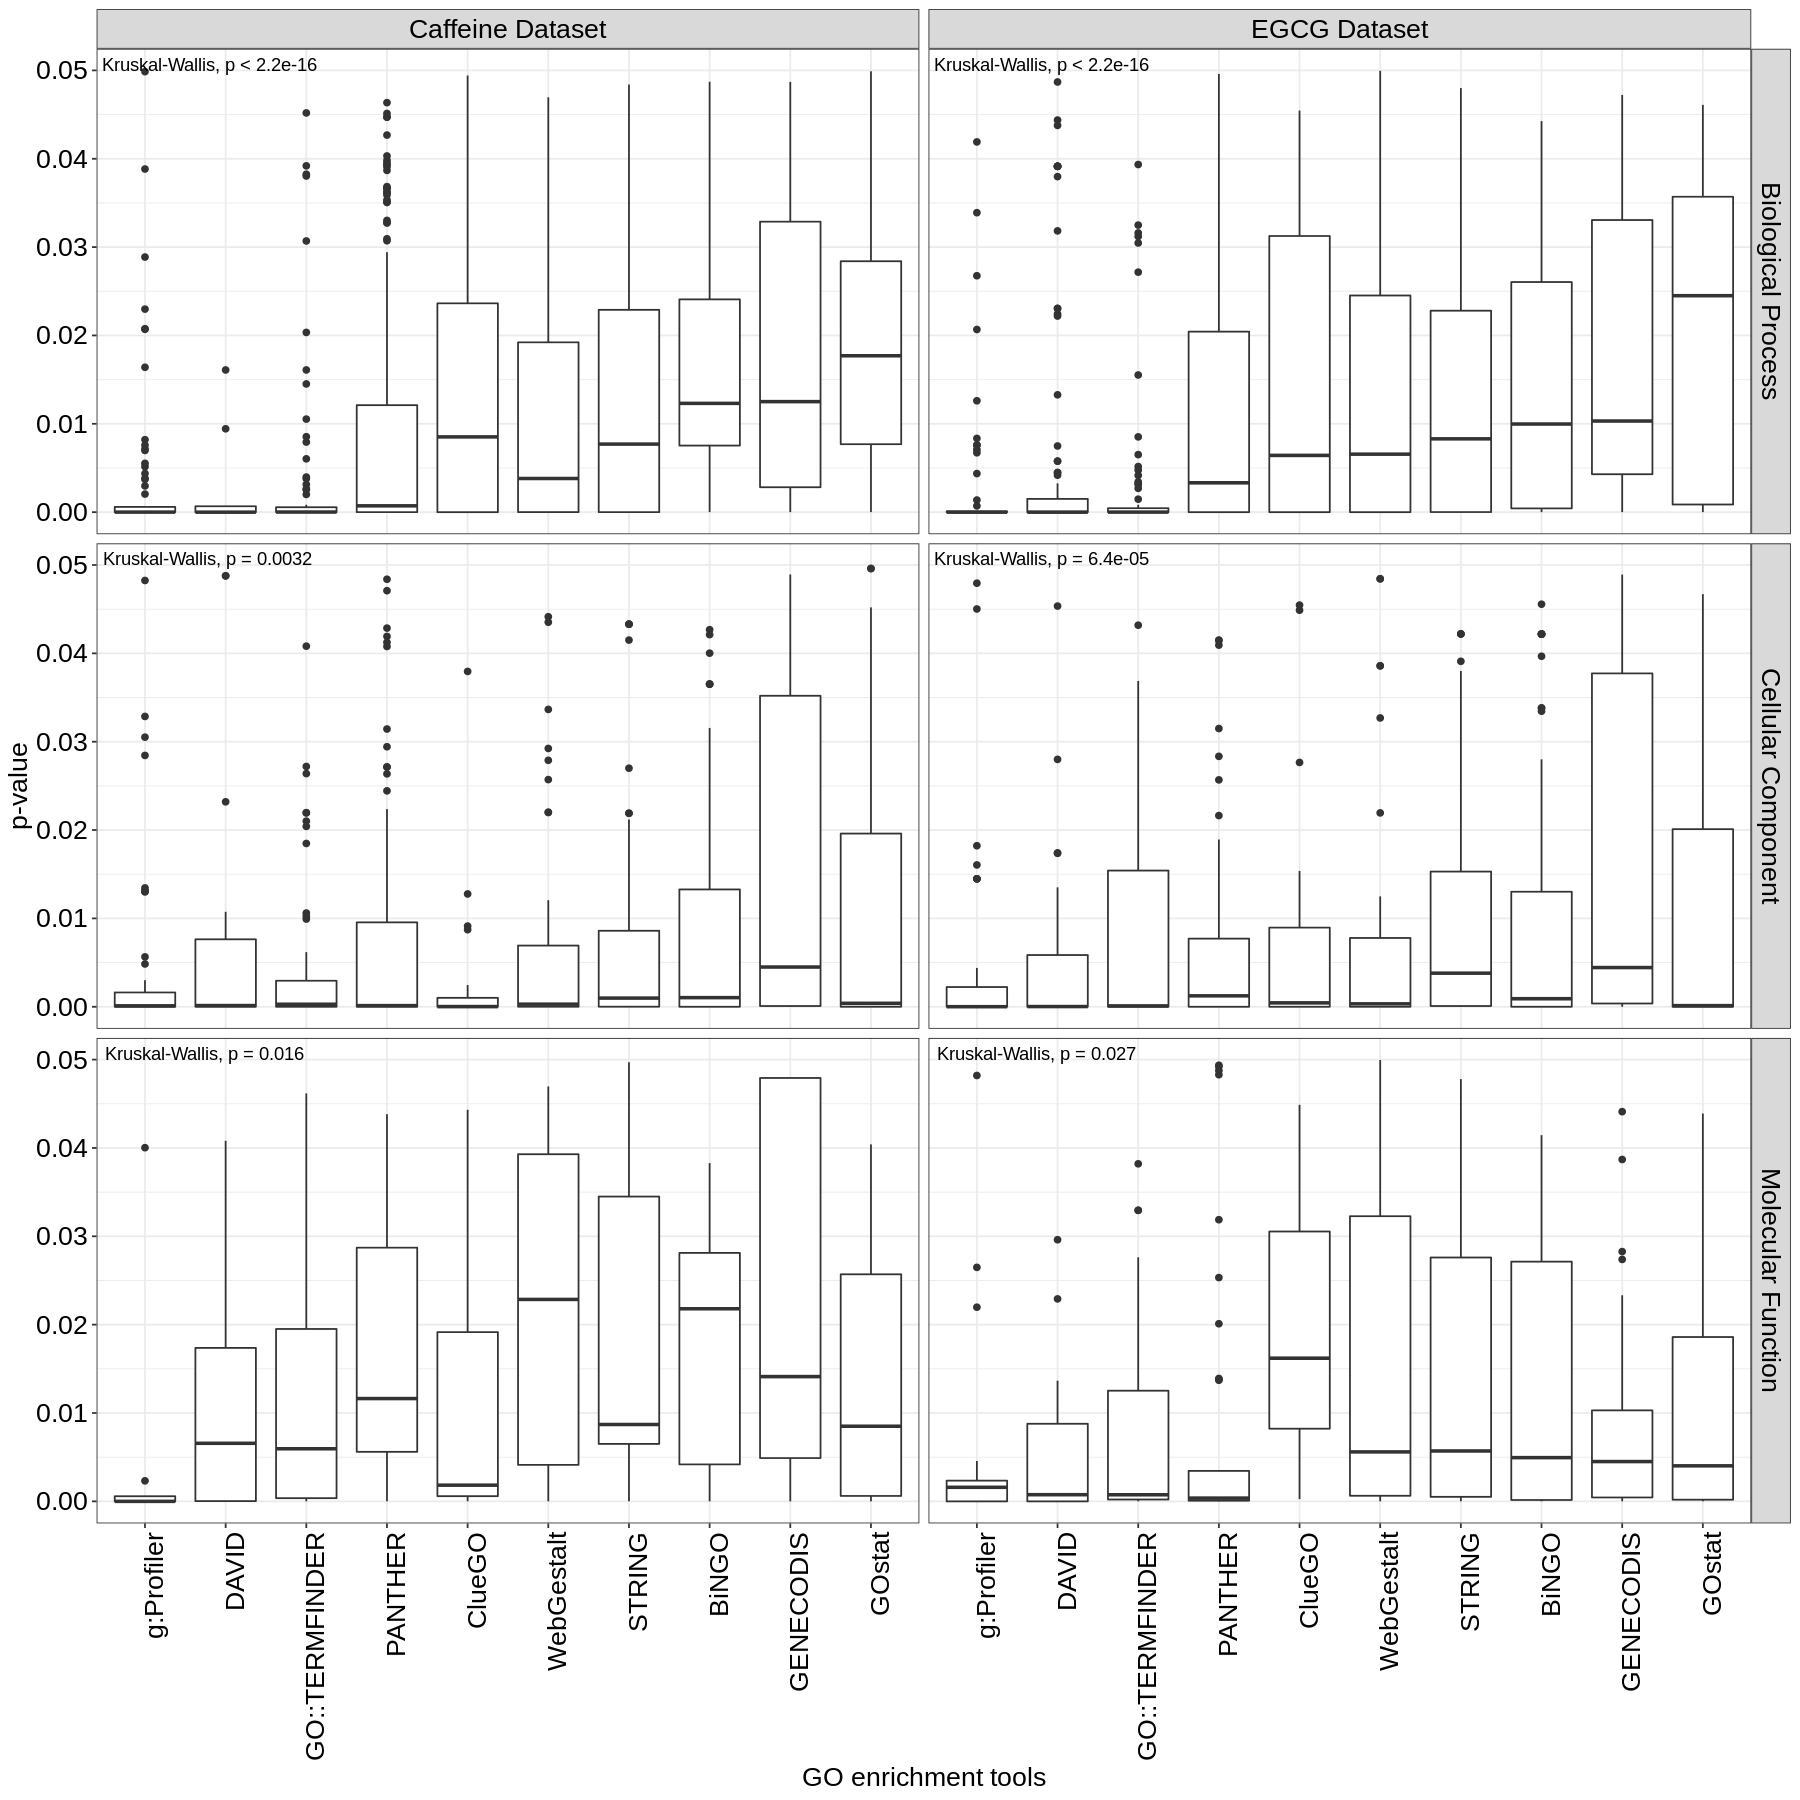

In [ ]:
df <- df_01[,-c(1,9)] %>% unique()
options(repr.plot.width=15, repr.plot.height=15)

ggplot(df,aes(reorder(database,fdr,median),fdr)) + geom_boxplot() + 
facet_grid(cols=vars(dataset),rows=vars(type)) + theme_bw() + font_custom  + stat_compare_means() + xlab("GO enrichment tools") + ylab("p-value")

#df.median <- df_01[,-c(1,2,4,5,9)] %>% group_by(type,dataset,database) %>% summarise(me_pavalue=median(fdr))
#df.median 

### ANOVA vs. F-test plus Pairwise

In [ ]:
all.pmedian <- df_01[,-c(1,9)] %>% unique() 
all.pmedian.index <- rbind(Caffeine.pmedian,EGCG.pmedian) %>% select(type,dataset) %>% unique()
all.pmedian.index %>% head()
all.pmedian %>% head()

In [ ]:
datalist <- list()
for (i in 1:nrow(all.pmedian.index)) {
all.test.01 <- all.pmedian %>% filter(.,type == all.pmedian.index[i,1] %>% unlist(),
                                            dataset == all.pmedian.index[i,2] %>% unlist())
res.aov <- kruskal.test(fdr ~ database, data = all.test.01)
res.1 <- tidy(res.aov)
res.1$type <- all.pmedian.index[i,1] %>% unlist()
res.1$dataset <-all.pmedian.index[i,2] %>% unlist()

PT = dunnTest(fdr ~ database,
              data=all.test.01,
              method="none")    

PT.02 <- PT$res %>% select(Comparison,P.adj) %>% as.data.frame() 
PT.03 <- PT.02 
rownames(PT.03) <- PT.02[,1]
PT.04 <- t(PT.03) %>% as.data.frame()
rownames(PT.04) <- NULL
res <- cbind(res.1,PT.04[-1,])
datalist[[i]] <- res
}
res.01 <- do.call(rbind,datalist) %>% unique() %>% as.data.frame() %>% select(-statistic,-parameter,) %>% setnames("p.value","All")
res.02 <- melt(data = res.01, id.vars = c("method", "type","dataset"))

Warning message:
“attributes are not identical across measure variables; they will be dropped”


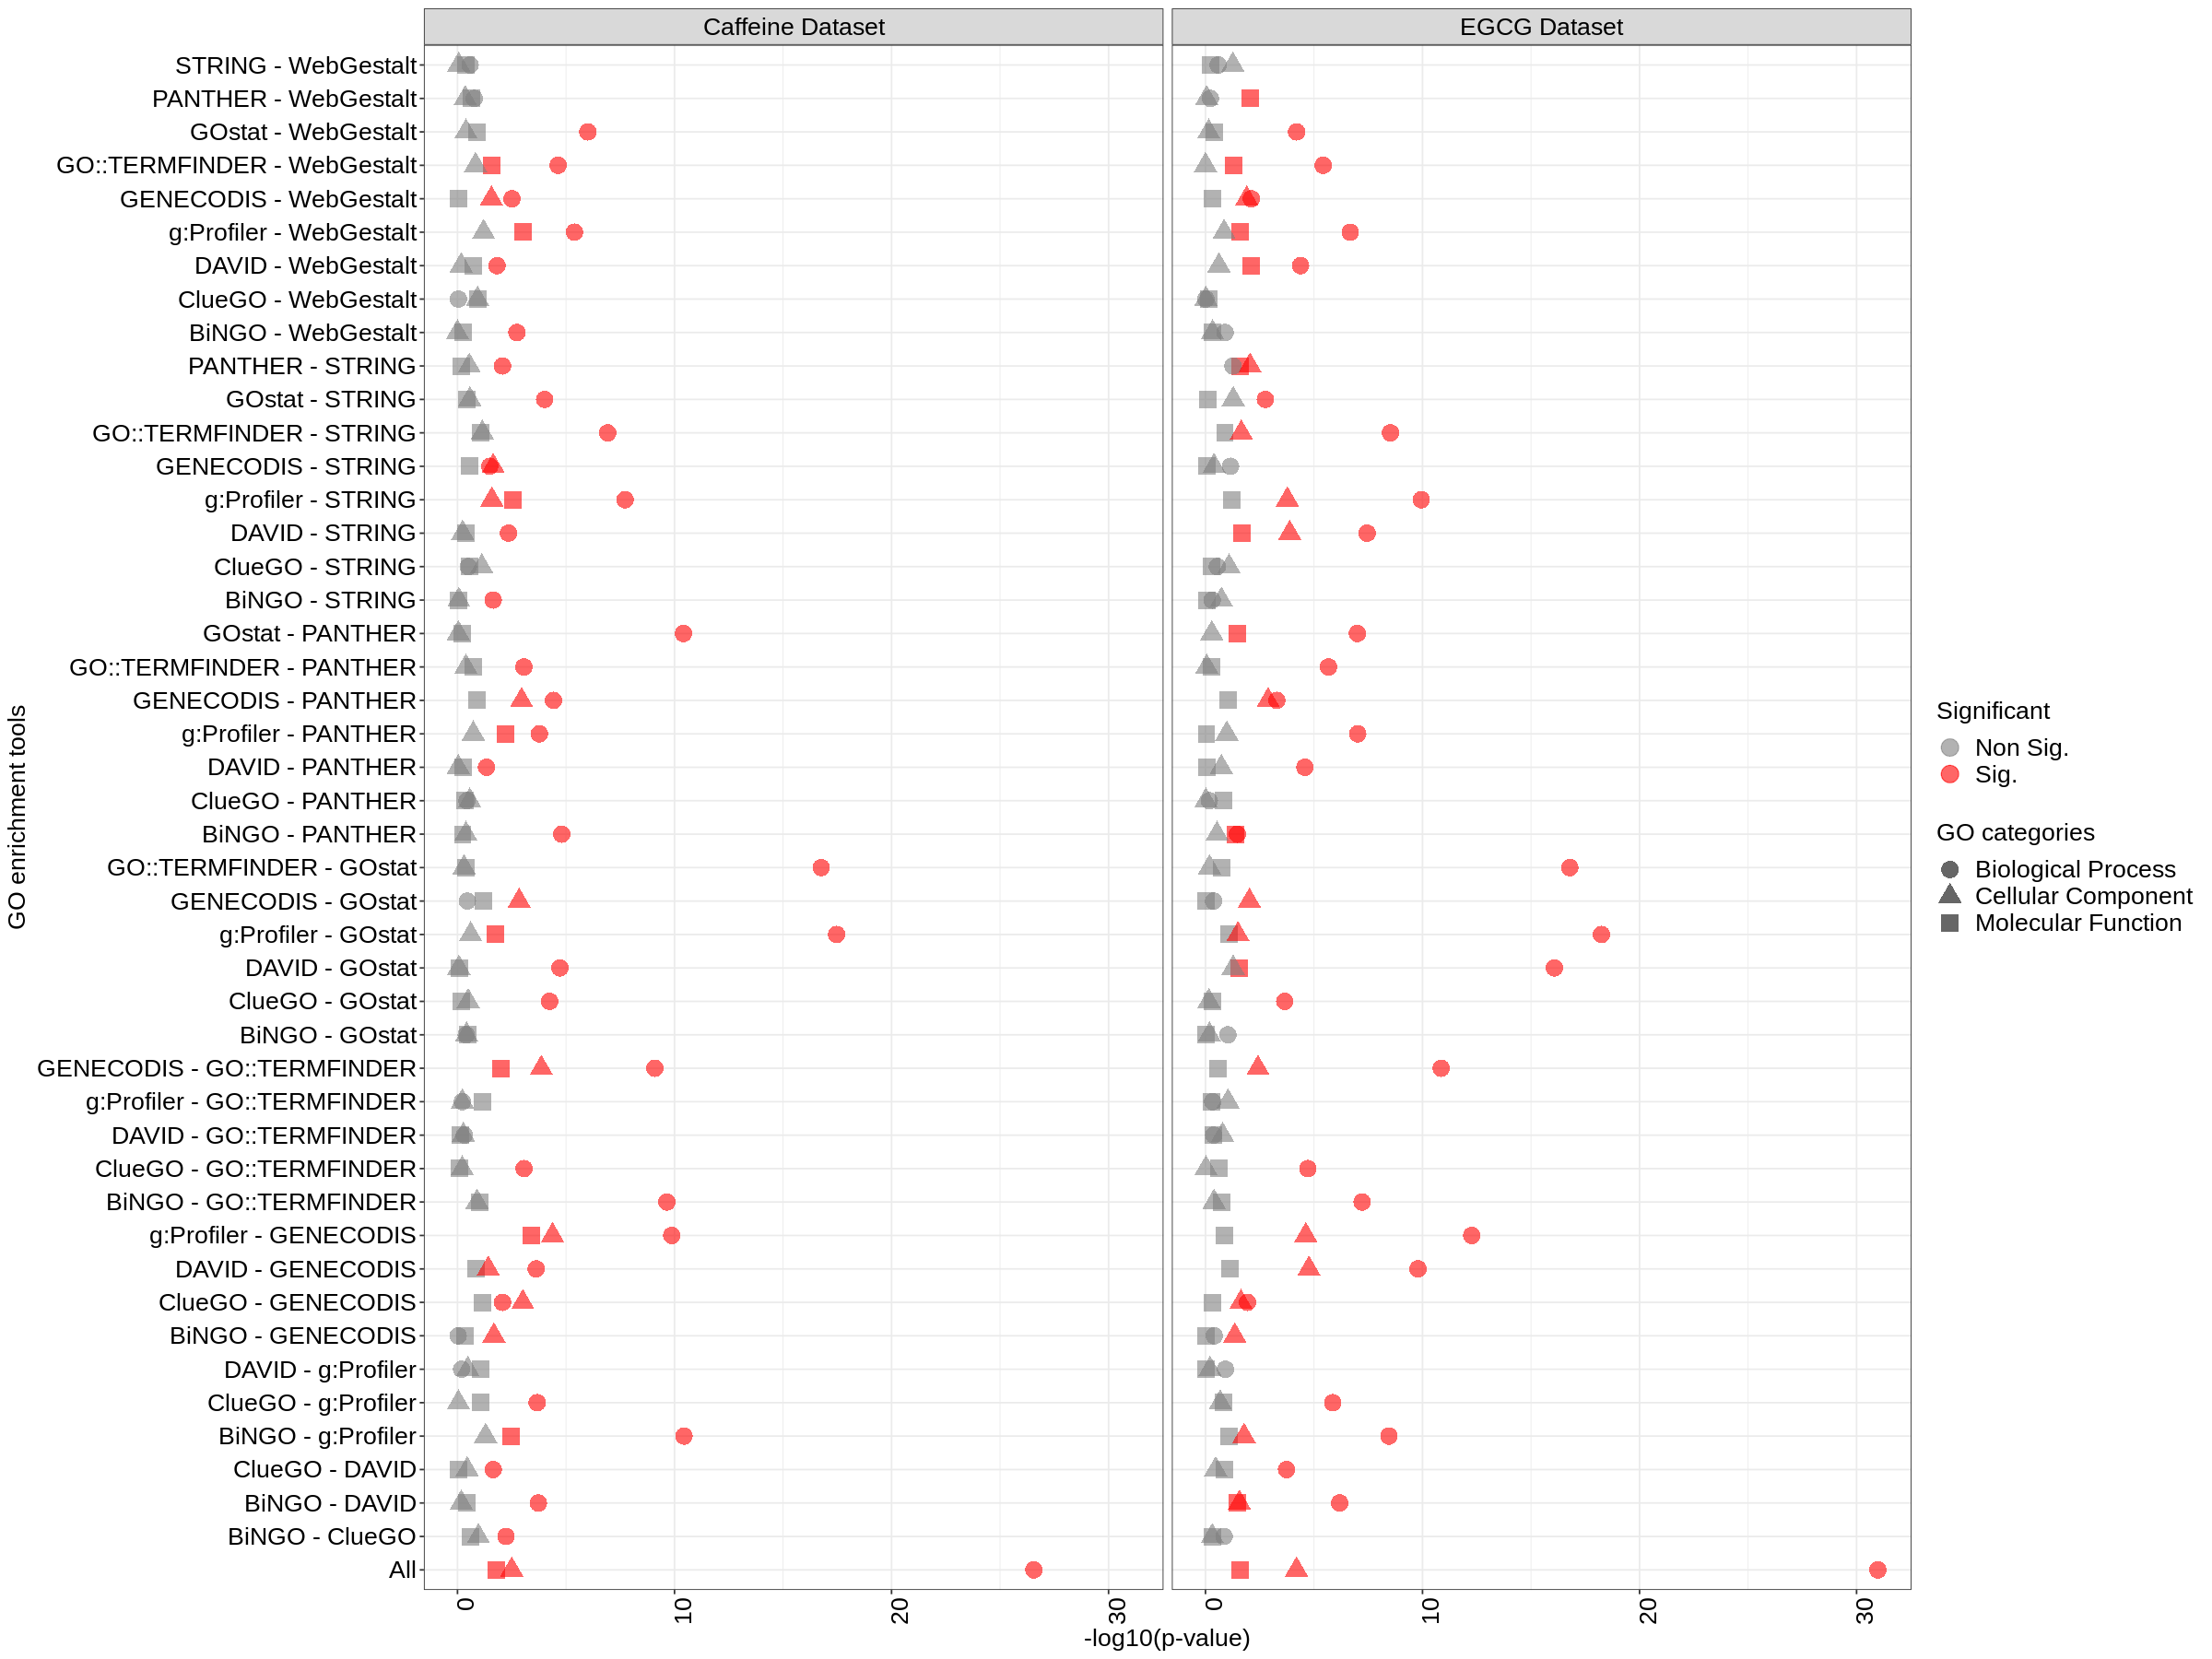

In [ ]:
options(repr.plot.width=20, repr.plot.height=15)
res.03 <- res.02 
res.03$value <- as.numeric(res.03$value)
res.03$con <- ifelse(res.03$value < 0.05,"Sig.","Non Sig.")
res.03$value_02 <- -log10(res.03$value)

res.03 %>% ggplot(aes(variable,value_02,color=con,shape=type)) + geom_point(size=5,alpha=0.6)  +
  scale_color_manual(values = c("Non Sig." = "grey50", "Sig." = "red")) + 
  facet_grid(cols=vars(dataset)) +
  theme_bw() +
  font_custom +
  coord_flip() +
  xlab("GO enrichment tools") +
  ylab("-log10(p-value)") +
  labs(shape="GO categories", color="Significant")


# Trend

In [ ]:
cdf <- rbind(GO_freq,annotate_gene,uniqueness_GO,IC_all,pvalue_all_final)
cdf$cat %>% unique()

[1] "Freq"           "Annotated Gene" "Uniquess"       "IC median"     
[5] "Me p-value"

In [ ]:
mani_df <- function(j,k){
  cdf <- rbind(GO_freq,annotate_gene,uniqueness_GO,IC_all,pvalue_all_final)%>% filter(cat == j,type == k) 
  cdf_02 <- cdf[,-1]
  rownames(cdf_02) <- cdf[,1]
  sumstat_frq <- cdf_02 %>% filter(cat==j) %>% group_by(type) %>% summarise(Ca=mean(Caffeine),EG=mean(EGCG))
  cdf_02$tools <- ifelse(cdf_02$Caffeine > sumstat_frq$Ca & cdf_02$EGCG > sumstat_frq$EG, "yes",
  ifelse(cdf_02$Caffeine < sumstat_frq$Ca & cdf_02$EGCG < sumstat_frq$EG,"yes",""))
  index_df <- which(cdf_02$tools == "yes") %>% as.vector()
  cdf_02$tool[index_df] <- rownames(cdf_02)[index_df]
  cdf_final <- cdf_02[,-5]
  return(cdf_final)
}


In [ ]:
Sum_stat_index <- function(j,k){
  cdf <- rbind(GO_freq,annotate_gene,uniqueness_GO,IC_all,pvalue_all_final)%>% filter(cat == j,type == k) 
  cdf_02 <- cdf[,-1]
  rownames(cdf_02) <- cdf[,1]
  sumstat_frq <- cdf_02 %>% filter(cat==j) %>% group_by(type) %>% mutate(Nor_EGCG = (EGCG-min(EGCG))/(max(EGCG)-min(EGCG)),
                                                Nor_Caffeine = (Caffeine-min(Caffeine))/(max(Caffeine)-min(Caffeine))) %>%
                                                group_by(type) %>% summarise(Me_caf = mean(Nor_Caffeine),Me_EGCG = mean(Nor_EGCG))
                                                  
  return(sumstat_frq)
}

In [ ]:
plot_graph <- function(i){
  BP_Freq <- mani_df(i,"Biological Process")
  MF_Freq <- mani_df(i,"Molecular Function")
  CC_Freq <- mani_df(i,"Cellular Component")

  BP_Index <- Sum_stat_index(i,"Biological Process")
  MF_Index <- Sum_stat_index(i,"Molecular Function")
  CC_Index <- Sum_stat_index(i,"Cellular Component")

  all_Freq <- rbind(BP_Freq,MF_Freq,CC_Freq) %>%  group_by(type) %>% mutate(Nor_EGCG = (EGCG-min(EGCG))/(max(EGCG)-min(EGCG)),
                                                Nor_Caffeine = (Caffeine-min(Caffeine))/(max(Caffeine)-min(Caffeine)))

  all_index <- rbind(BP_Index,CC_Index,MF_Index)
  options(repr.plot.width=15, repr.plot.height=6)
  ggplot(all_Freq,aes(Nor_Caffeine,Nor_EGCG)) +
  geom_point(color = ifelse(all_Freq$tool == "", "grey50", "red"),size=3) +
  facet_grid(cols=vars(type)) +
  geom_label_repel(aes(label = tool),
                     box.padding   = 0.65, 
                     point.padding = 0.35,
                    segment.color = 'grey50')+ 
   geom_vline(data = all_index[,c("type","Me_caf")], aes(xintercept = Me_caf),linetype = 2,color="grey") +
   geom_hline(data = all_index[,c("type","Me_EGCG")], aes(yintercept = Me_EGCG),linetype = 2,color="grey") +
   font_custom +
   theme_bw() +
   xlab("Caffeine Dataset") +
   ylab("EGCG Dataset")

}


##Plot


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



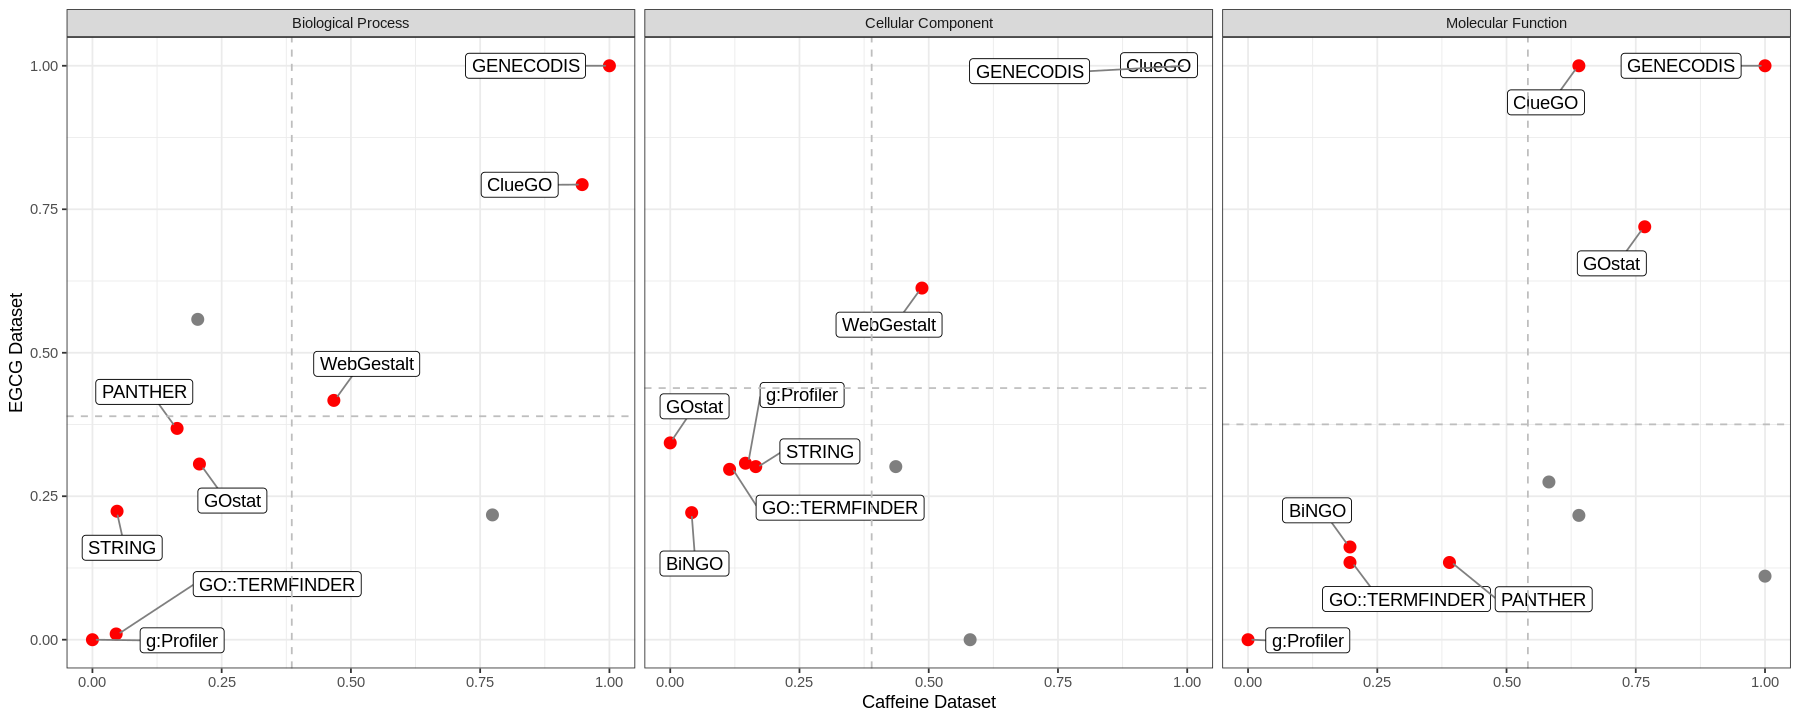

In [ ]:
#plot_graph("Freq")
#plot_graph("Annotated Gene")
#plot_graph("Uniquess")
plot_graph("IC median")
#plot_graph("Me p-value")